# Wikipedia Article Classification with Graph Neural Networks

This notebook implements a Graph Neural Network (GNN) approach for classifying Wikipedia articles in the Wikispeedia dataset. We will use the graph structure of Wikipedia hyperlinks along with article features to predict article categories.

## Project Overview
- Convert the Wikispeedia navigation dataset into a node classification problem
- Extract meaningful features from articles and graph topology
- Implement and evaluate various GNN architectures for classification
- Compare performance against non-graph baselines
- Analyze patterns in the classification results

## Dataset Description
The Wikispeedia dataset contains:
- Wikipedia articles and their hyperlink connections
- Human navigation paths through the Wikipedia network
- Article categories and metadata
- Shortest path distances between articles

We'll repurpose this dataset, originally designed for navigation path prediction, into a node classification task.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, GraphSAGE, GATv2Conv, JumpingKnowledge, SAGEConv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm
import urllib.parse
import re
from collections import Counter

# Set up plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Set paths
DATA_PATH = 'MSBD5008_Social-Computing'
ARTICLES_PATH = os.path.join(DATA_PATH, 'plaintext_articles')
WIKISPEEDIA_PATH = os.path.join(DATA_PATH, 'wikispeedia_paths-and-graph')

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 
                      'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading and Preprocessing

In this section, we'll load the Wikispeedia dataset and preprocess it for node classification:
- Load articles, links, categories, and path data
- Map articles to unique indices
- Decode URL-encoded article names
- Explore the dataset statistics

In [2]:
# Load the Wikispeedia dataset
def load_tsv_file(filepath, comment_char='#', delimiter='\t'):
    """Load TSV file, skipping comment lines."""
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if not line.startswith(comment_char)]
    
    if len(lines) == 0:
        return pd.DataFrame()
    
    # Parse the data based on delimiter
    data = [line.split(delimiter) for line in lines]
    return pd.DataFrame(data)

# Load articles list
articles_file = os.path.join(WIKISPEEDIA_PATH, 'articles.tsv')
articles_df = load_tsv_file(articles_file)
articles_df = articles_df.dropna()
articles_df.columns = ['article']
# Decode URL-encoded article names
articles_df['article_decoded'] = articles_df['article'].apply(lambda x: urllib.parse.unquote(x) if x is not None else None)

# Load links between articles
links_file = os.path.join(WIKISPEEDIA_PATH, 'links.tsv')
links_df = load_tsv_file(links_file)
links_df = links_df.dropna()
links_df.columns = ['linkSource', 'linkTarget']
# Decode URL-encoded article names
links_df['source_decoded'] = links_df['linkSource'].apply(lambda x: urllib.parse.unquote(x) if x is not None else None)
links_df['target_decoded'] = links_df['linkTarget'].apply(lambda x: urllib.parse.unquote(x) if x is not None else None)

# Load categories
categories_file = os.path.join(WIKISPEEDIA_PATH, 'categories.tsv')
categories_df = load_tsv_file(categories_file)
categories_df = categories_df.dropna()
categories_df.columns = ['article', 'category']
categories_df['article_decoded'] = categories_df['article'].apply(lambda x: urllib.parse.unquote(x) if x is not None else None)
categories_df['category_decoded'] = categories_df['category'].apply(lambda x: urllib.parse.unquote(x) if x is not None else None)

# Load finished paths
finished_paths_file = os.path.join(WIKISPEEDIA_PATH, 'paths_finished.tsv')
finished_paths_df = load_tsv_file(finished_paths_file)
if not finished_paths_df.empty:
    finished_paths_df.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
    finished_paths_df = finished_paths_df.dropna()

# Display basic statistics
print(f"Number of articles: {len(articles_df) if not articles_df.empty else 'Data not loaded'}")
print(f"Number of links: {len(links_df) if not links_df.empty else 'Data not loaded'}")
print(f"Number of categories entries: {len(categories_df) if not categories_df.empty else 'Data not loaded'}")
print(f"Number of finished paths: {len(finished_paths_df) if not finished_paths_df.empty else 'Data not loaded'}")

# Create article ID mapping (for node indices in the graph)
article_to_idx = {article: i for i, article in enumerate(articles_df['article'])}
idx_to_article = {i: article for article, i in article_to_idx.items()}

# Display some sample articles with decoded names
print("\nSample articles:")
sample_articles = articles_df.sample(5)
for _, row in sample_articles.iterrows():
    print(f"  {row['article_decoded']} (ID: {article_to_idx[row['article']]})")

Number of articles: 4605
Number of links: 119882
Number of categories entries: 5204
Number of finished paths: 51318

Sample articles:
  Ursuline_Convent_Riots (ID: 4329)
  Allegory_in_the_Middle_Ages (ID: 199)
  University_of_Chicago (ID: 4313)
  1980_eruption_of_Mount_St._Helens (ID: 23)
  Spherical_aberration (ID: 3844)


Number of nodes: 4592
Number of edges: 119882
Is connected (weakly): False
Average in-degree: 26.11
Average out-degree: 26.11

Top 10 articles by in-degree (most linked to):
  United_States: 1551
  United_Kingdom: 972
  France: 959
  Europe: 933
  World_War_II: 751
  England: 751
  Germany: 743
  India: 611
  English_language: 598
  London: 587

Top 10 articles by out-degree (most outgoing links):
  United_States: 294
  Driving_on_the_left_or_right: 255
  List_of_countries: 244
  List_of_circulating_currencies: 236
  List_of_sovereign_states: 216
  Africa: 212
  List_of_countries_by_system_of_government: 207
  Lebanon: 192
  Interpol: 191
  Armenia: 186

Path Statistics:
Average path length: 6.76
Average back clicks: 0.40


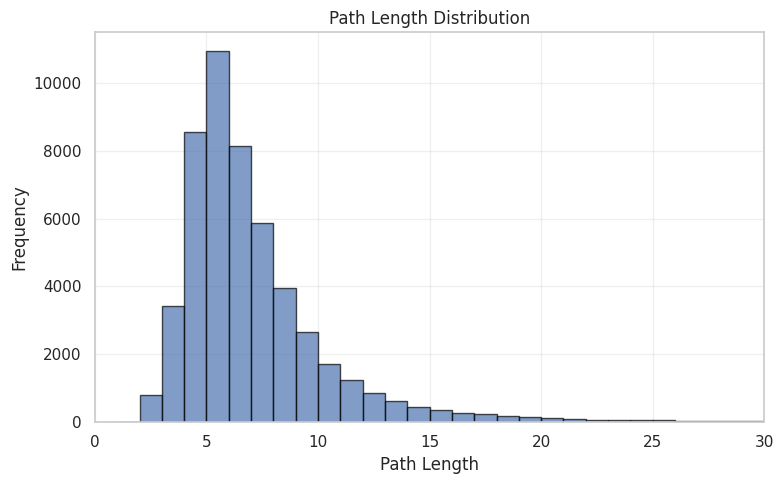

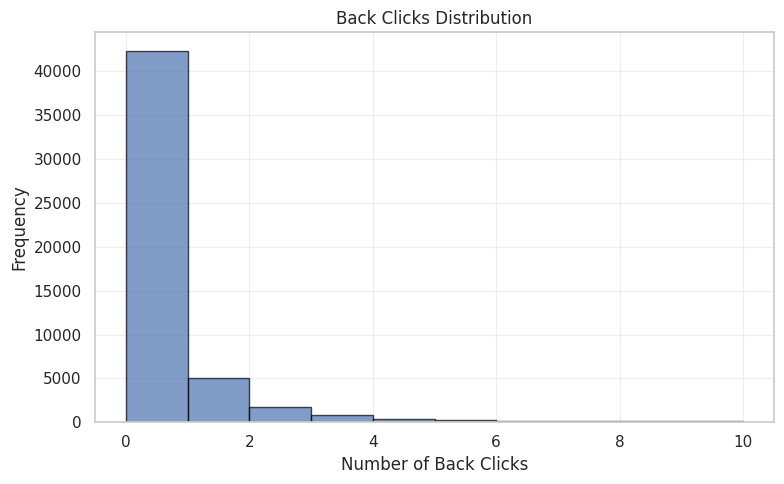

In [3]:
# Exploratory Data Analysis

# Create a directed graph
wiki_graph = nx.DiGraph()

# Add edges
for _, row in links_df.iterrows():
    wiki_graph.add_edge(row['source_decoded'], row['target_decoded'])

# Basic graph metrics
print(f"Number of nodes: {wiki_graph.number_of_nodes()}")
print(f"Number of edges: {wiki_graph.number_of_edges()}")
print(f"Is connected (weakly): {nx.is_weakly_connected(wiki_graph)}")
print(f"Average in-degree: {sum(dict(wiki_graph.in_degree()).values()) / wiki_graph.number_of_nodes():.2f}")
print(f"Average out-degree: {sum(dict(wiki_graph.out_degree()).values()) / wiki_graph.number_of_nodes():.2f}")

# Find top 10 articles by degree
in_degrees = dict(wiki_graph.in_degree())
out_degrees = dict(wiki_graph.out_degree())

top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 articles by in-degree (most linked to):")
for article, degree in top_in_degree:
    decoded = urllib.parse.unquote(article)
    print(f"  {decoded}: {degree}")

print("\nTop 10 articles by out-degree (most outgoing links):")
for article, degree in top_out_degree:
    decoded = urllib.parse.unquote(article)
    print(f"  {decoded}: {degree}")

# Analyze path statistics
def extract_path_details(path_str):
    # Check if path_str is None
    if path_str is None:
        return {
            'length': 0,
            'back_clicks': 0,
        }
    
    steps = path_str.split(';')
    back_clicks = steps.count('<')

    return {
        'length': len(steps),
        'back_clicks': back_clicks,
    }

# Apply to each path
path_details = []
for _, row in finished_paths_df.iterrows():
    details = extract_path_details(row['path'])
    path_details.append(details)

path_stats_df = pd.DataFrame(path_details)

# Generate summary statistics
print("\nPath Statistics:")
print(f"Average path length: {path_stats_df['length'].mean():.2f}")  # 6.76
print(f"Average back clicks: {path_stats_df['back_clicks'].mean():.2f}")  # 0.40

# Path length distribution
plt.figure(figsize=(8, 5))
plt.hist(path_stats_df['length'], bins=range(1, 31), alpha=0.7, edgecolor='black')
plt.title('Path Length Distribution')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.xlim(0, 30)  # Limiting x-axis to show relevant range based on average of 6.76
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Back clicks distribution
plt.figure(figsize=(8, 5))
plt.hist(path_stats_df['back_clicks'], bins=range(0, 11), alpha=0.7, edgecolor='black')
plt.title('Back Clicks Distribution')
plt.xlabel('Number of Back Clicks')
plt.ylabel('Frequency')
plt.xlim(-0.5, 10.5)  # Limiting x-axis since average is only 0.40
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Main categories distribution:
              main_category  article_count
14                  Science           1105
6                 Geography           1063
12                   People            676
7                   History            525
5             Everyday_life            369
4     Design_and_Technology            247
3                 Countries            229
2               Citizenship            215
9   Language_and_literature            194
13                 Religion            131
11                    Music             97
1          Business_Studies             87
8                        IT             84
10              Mathematics             45
0                       Art             38


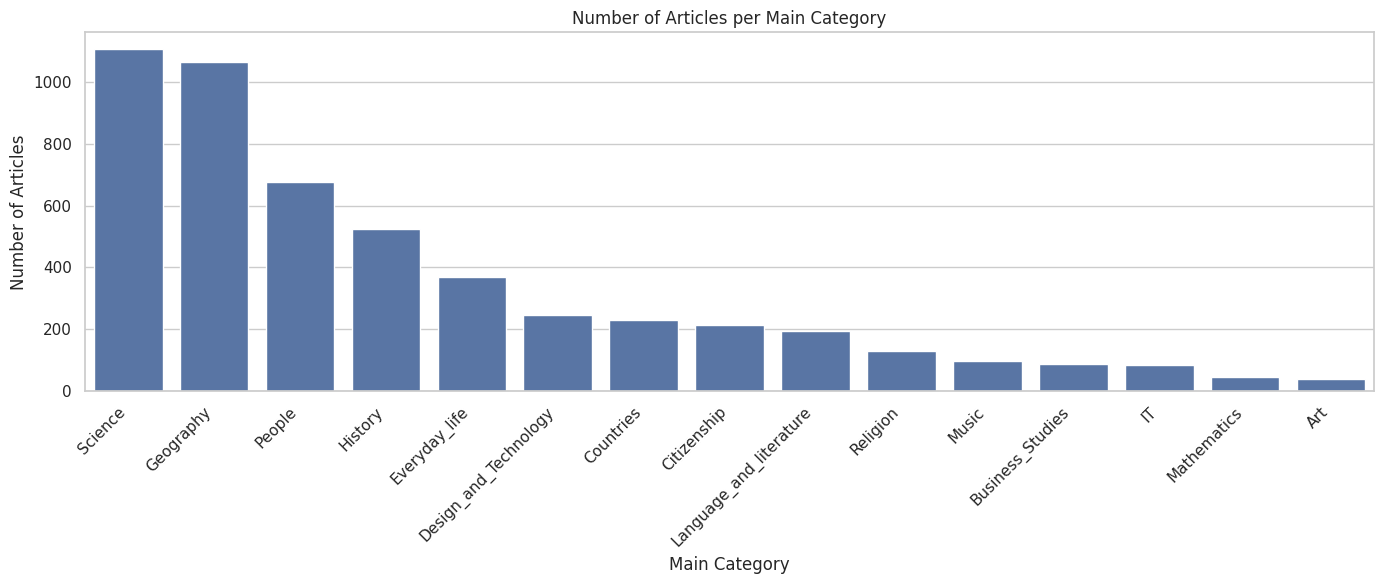

In [4]:
# Analyze categories for classification task
categories_df['main_category'] = categories_df['category'].str.split('.').str[1]

# Count articles per main category
category_counts = categories_df.groupby('main_category')['article'].nunique().reset_index()
category_counts.columns = ['main_category', 'article_count']
category_counts = category_counts.sort_values('article_count', ascending=False)

print("Main categories distribution:")
print(category_counts)

# Plot category distribution
plt.figure(figsize=(14, 6))
sns.barplot(x='main_category', y='article_count', data=category_counts)
plt.title('Number of Articles per Main Category')
plt.xlabel('Main Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate how many categories each article belongs to
article_category_counts = categories_df.groupby('article')['main_category'].count().reset_index()
article_category_counts.columns = ['article', 'category_count']

## 2. Graph Construction and Exploration

In this section, we'll:
- Construct a directed graph representation of the Wikipedia hyperlink network
- Calculate graph metrics such as degree, centrality measures
- Identify important hub articles
- Visualize the graph structure

In [5]:
# Construct a directed graph from the links data
wiki_graph = nx.DiGraph()

# Add all articles as nodes first
for article in articles_df['article']:
    wiki_graph.add_node(article)

# Add edges from links
for _, row in links_df.iterrows():
    wiki_graph.add_edge(row['linkSource'], row['linkTarget'])

# Calculate basic graph metrics
print(f"Number of nodes: {wiki_graph.number_of_nodes()}")
print(f"Number of edges: {wiki_graph.number_of_edges()}")
print(f"Is connected (weakly): {nx.is_weakly_connected(wiki_graph)}")
print(f"Average in-degree: {sum(dict(wiki_graph.in_degree()).values()) / wiki_graph.number_of_nodes():.2f}")
print(f"Average out-degree: {sum(dict(wiki_graph.out_degree()).values()) / wiki_graph.number_of_nodes():.2f}")

# Find top articles by degree
in_degrees = dict(wiki_graph.in_degree())
out_degrees = dict(wiki_graph.out_degree())

top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 articles by in-degree (most linked to):")
for article, degree in top_in_degree:
    decoded = urllib.parse.unquote(article)
    print(f"  {decoded}: {degree}")

print("\nTop 10 articles by out-degree (most outgoing links):")
for article, degree in top_out_degree:
    decoded = urllib.parse.unquote(article)
    print(f"  {decoded}: {degree}")

# Calculate connected components
weakly_connected_components = list(nx.weakly_connected_components(wiki_graph))
print(f"\nNumber of weakly connected components: {len(weakly_connected_components)}")
largest_component = max(weakly_connected_components, key=len)
print(f"Size of largest weakly connected component: {len(largest_component)} nodes "
      f"({len(largest_component)/wiki_graph.number_of_nodes()*100:.2f}% of all nodes)")

Number of nodes: 4605
Number of edges: 119882
Is connected (weakly): False
Average in-degree: 26.03
Average out-degree: 26.03

Top 10 articles by in-degree (most linked to):
  United_States: 1551
  United_Kingdom: 972
  France: 959
  Europe: 933
  England: 751
  World_War_II: 751
  Germany: 743
  India: 611
  English_language: 598
  London: 587

Top 10 articles by out-degree (most outgoing links):
  United_States: 294
  Driving_on_the_left_or_right: 255
  List_of_countries: 244
  List_of_circulating_currencies: 236
  List_of_sovereign_states: 216
  Africa: 212
  List_of_countries_by_system_of_government: 207
  Lebanon: 192
  Interpol: 191
  Armenia: 186

Number of weakly connected components: 15
Size of largest weakly connected component: 4589 nodes (99.65% of all nodes)


Computing centrality metrics (this may take a while)...

Top 15 articles by PageRank:
  United_States: 0.009561
  France: 0.006420
  Europe: 0.006337
  United_Kingdom: 0.006232
  English_language: 0.004863
  Germany: 0.004822
  World_War_II: 0.004722
  England: 0.004472
  Latin: 0.004422
  India: 0.004034
  Japan: 0.003888
  Italy: 0.003716
  Spain: 0.003641
  China: 0.003564
  Russia: 0.003495


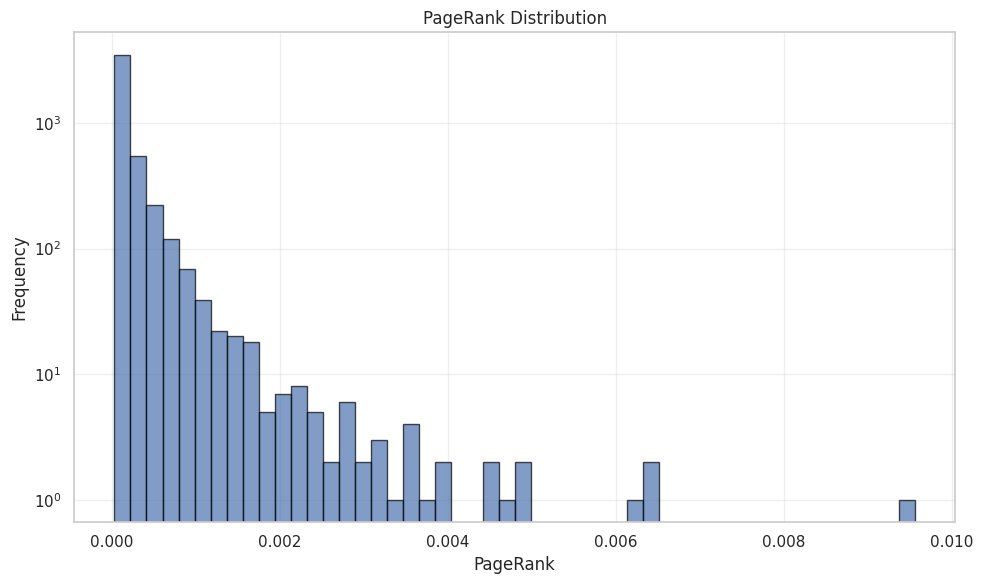

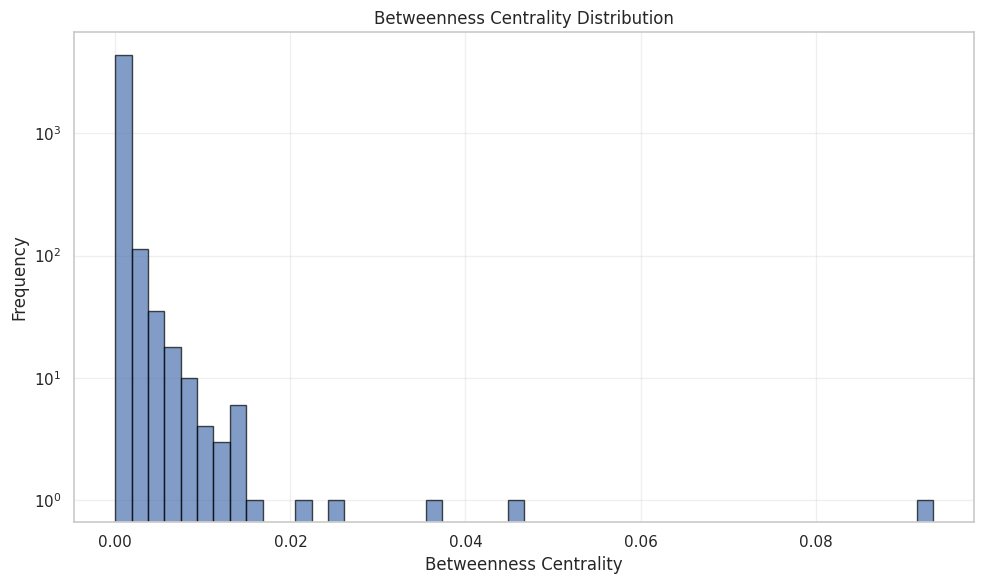

In [6]:
# Calculate centrality measures for the graph
print("Computing centrality metrics (this may take a while)...")

# PageRank - measure of node importance
pagerank = nx.pagerank(wiki_graph, alpha=0.85, max_iter=100)

# Betweenness centrality - measures how often a node lies on shortest paths
# Using approximation for large graphs
betweenness = nx.betweenness_centrality(wiki_graph, k=100, normalized=True)

# In-degree and out-degree centrality
in_degree_centrality = nx.in_degree_centrality(wiki_graph)
out_degree_centrality = nx.out_degree_centrality(wiki_graph)

# Create a DataFrame with centrality metrics
centrality_df = pd.DataFrame({
    'article': list(wiki_graph.nodes()),
    'pagerank': [pagerank.get(node, 0) for node in wiki_graph.nodes()],
    'betweenness': [betweenness.get(node, 0) for node in wiki_graph.nodes()],
    'in_degree_centrality': [in_degree_centrality.get(node, 0) for node in wiki_graph.nodes()],
    'out_degree_centrality': [out_degree_centrality.get(node, 0) for node in wiki_graph.nodes()]
})

# Add decoded article names
centrality_df['article_decoded'] = centrality_df['article'].apply(lambda x: urllib.parse.unquote(x))

# Sort by PageRank and show top articles
top_pagerank = centrality_df.sort_values(by='pagerank', ascending=False).head(15)

print("\nTop 15 articles by PageRank:")
for idx, row in top_pagerank.iterrows():
    print(f"  {row['article_decoded']}: {row['pagerank']:.6f}")

# PageRank distribution
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['pagerank'], bins=50, alpha=0.7, edgecolor='black')
plt.title('PageRank Distribution')
plt.xlabel('PageRank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Betweenness distribution
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['betweenness'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Visualizing subgraph around: United_States


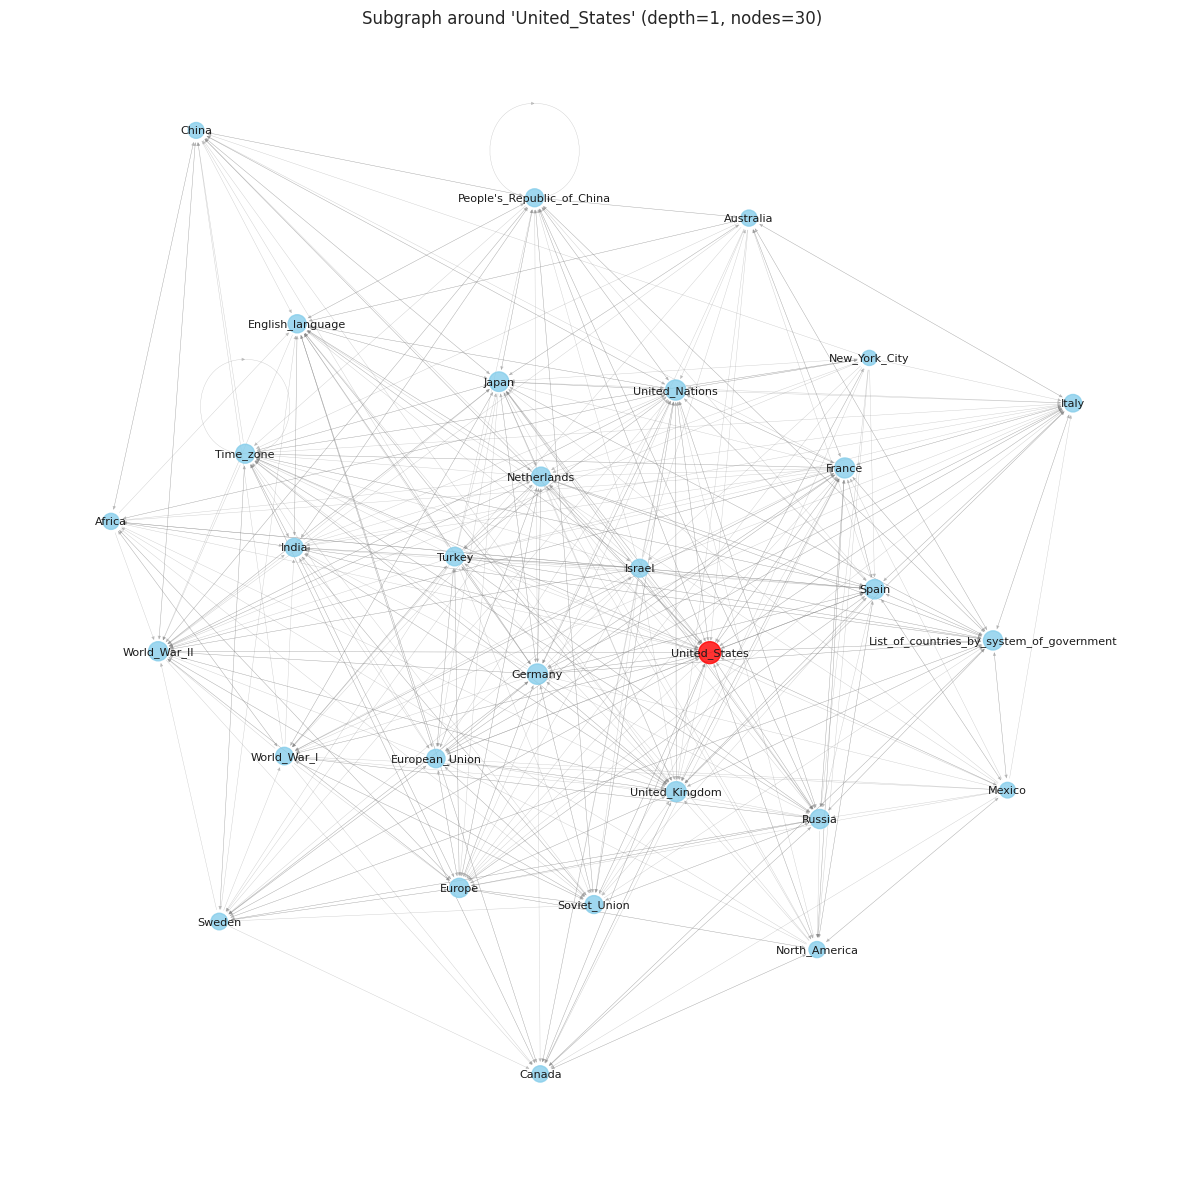

Visualizing subgraph around: Europe


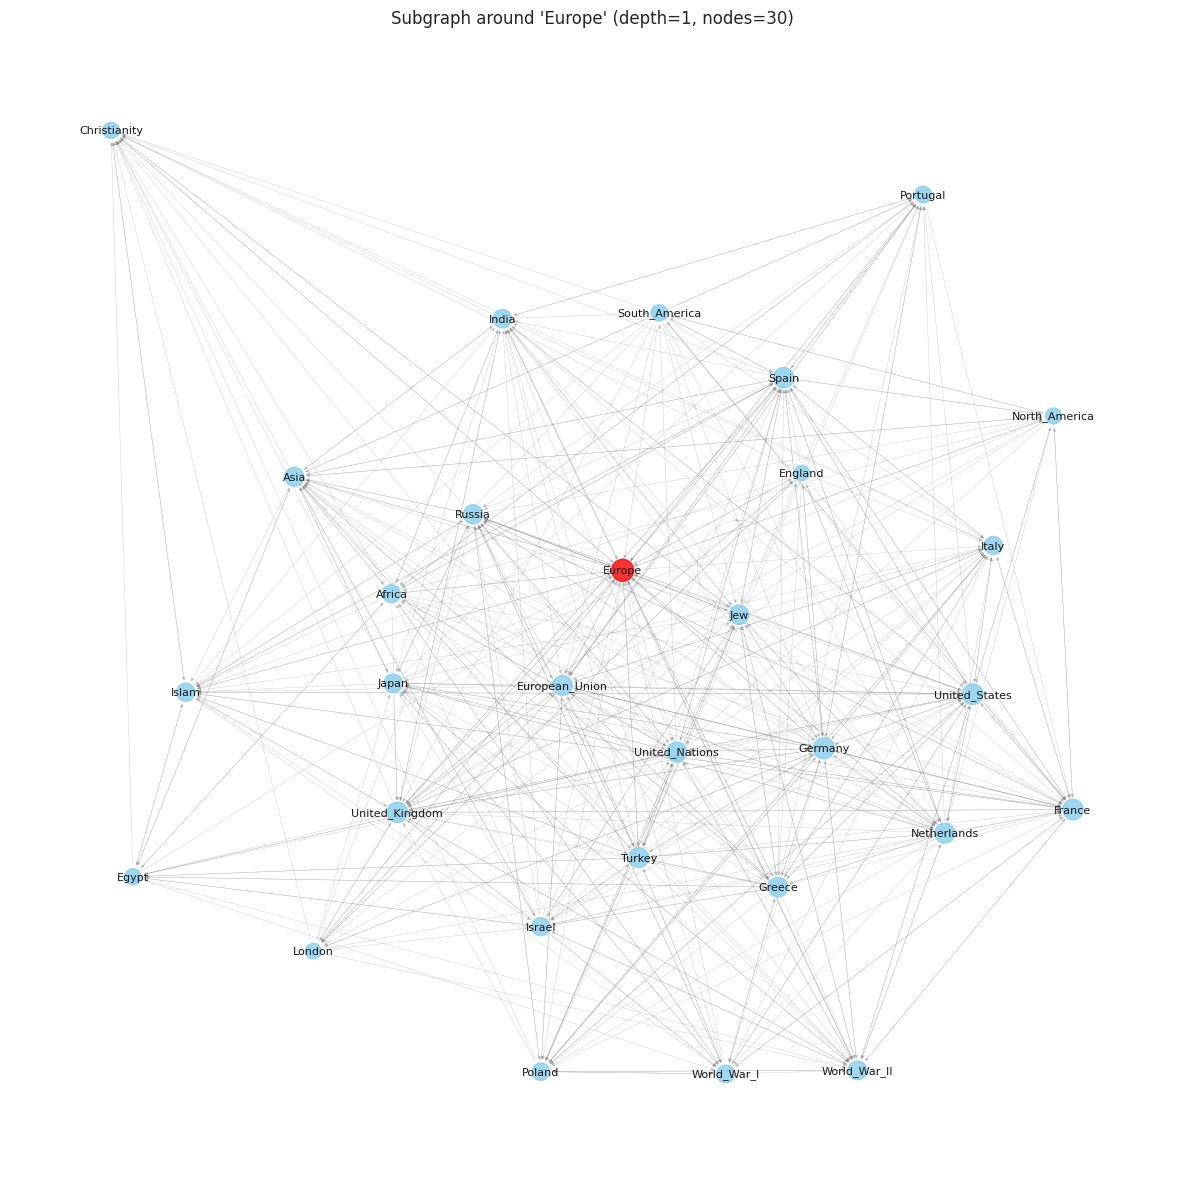

In [7]:
# Visualize a subset of the graph for exploration
def visualize_graph_subset(graph, central_node, depth=1, max_nodes=50):
    """
    Visualize a subset of the graph around a central node.
    
    Parameters:
    - graph: NetworkX graph
    - central_node: The central node to start from
    - depth: How many steps outward to include
    - max_nodes: Maximum number of nodes to visualize
    """
    # Extract subgraph using BFS with node limit
    nodes = {central_node}
    frontier = {central_node}
    
    for _ in range(depth):
        new_frontier = set()
        for node in frontier:
            if len(nodes) >= max_nodes:
                break  # Stop if reached max_nodes
            new_frontier.update(graph.successors(node))
            new_frontier.update(graph.predecessors(node))
        frontier = new_frontier - nodes
        nodes.update(frontier)
        if len(nodes) >= max_nodes:
            break
    
    subgraph = graph.subgraph(nodes)
    
    # If still too large, keep only top-degree nodes
    if len(subgraph) > max_nodes:
        degrees = dict(subgraph.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: -degrees[x])[:max_nodes]
        subgraph = graph.subgraph(top_nodes)
    
    # Set up visualization
    plt.figure(figsize=(12, 12))
    
    # Dynamic layout adjustment
    pos = nx.spring_layout(subgraph, seed=SEED)
    
    # Node sizes (scaled by degree)
    node_degrees = dict(subgraph.degree())
    max_degree = max(node_degrees.values()) if node_degrees else 1
    node_sizes = [50 + 200 * (node_degrees[n] / max_degree) for n in subgraph]
    
    # Node colors (based on categories if available)
    # For this example, just highlight the central node in red
    node_colors = ['red' if n == central_node else 'skyblue' for n in subgraph]
    
    # Draw edges
    nx.draw_networkx_edges(
        subgraph, pos,
        width=0.3,
        alpha=0.4,
        edge_color='gray',
        arrowsize=5
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        subgraph, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.8
    )
    
    # Label nodes
    labels = {n: urllib.parse.unquote(n) for n in subgraph}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    plt.title(f"Subgraph around '{urllib.parse.unquote(central_node)}' (depth={depth}, nodes={len(subgraph)})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize subgraph around a top PageRank article
central_article = top_pagerank.iloc[0]['article']
print(f"Visualizing subgraph around: {urllib.parse.unquote(central_article)}")
visualize_graph_subset(wiki_graph, central_article, depth=1, max_nodes=30)

# Visualize another subgraph with a different central node
second_article = top_pagerank.iloc[2]['article']
print(f"Visualizing subgraph around: {urllib.parse.unquote(second_article)}")
visualize_graph_subset(wiki_graph, second_article, depth=1, max_nodes=30)

## 3. Feature Engineering for Node Classification

In this section, we'll:
- Extract features for each node (article) from different data sources
- Combine graph topology features with article metadata
- Apply dimensionality reduction techniques
- Prepare features for GNN input

In [8]:
# Create features for articles based on multiple data sources

# 1. Graph topology features
graph_features = pd.DataFrame({
    'article': list(wiki_graph.nodes()),
    'pagerank': [pagerank.get(node, 0) for node in wiki_graph.nodes()],
    'betweenness': [betweenness.get(node, 0) for node in wiki_graph.nodes()],
    'in_degree': [wiki_graph.in_degree(node) for node in wiki_graph.nodes()],
    'out_degree': [wiki_graph.out_degree(node) for node in wiki_graph.nodes()],
    'total_degree': [wiki_graph.degree(node) for node in wiki_graph.nodes()]
})

# 2. Path-based features - how often articles appear in navigation paths
if not finished_paths_df.empty:
    print("Adding path-based features...")
    
    # Extract all articles in paths and count occurrences
    all_path_articles = []
    
    for path_str in finished_paths_df['path']:
        if path_str is None:
            continue
        # Split path into individual articles
        articles = [a for a in path_str.split(';') if a != '<']
        all_path_articles.extend(articles)
    
    # Count occurrences of each article in paths
    article_path_counts = Counter(all_path_articles)
    
    # Add path occurrences to features
    graph_features['path_occurrences'] = graph_features['article'].map(
        lambda x: article_path_counts.get(x, 0)
    )
    
    print(f"Articles appearing in paths: {len(article_path_counts)} out of {len(graph_features)}")
else:
    # If path data not available, add zero column
    graph_features['path_occurrences'] = 0

# 3. Category-based features
print("Adding category-based features...")

# Get main categories for each article
categories_df['main_category'] = categories_df['category'].str.split('.').str[1]

# Calculate number of categories per article
category_counts = categories_df.groupby('article').size().reset_index(name='category_count')
graph_features = graph_features.merge(category_counts, on='article', how='left')
graph_features['category_count'] = graph_features['category_count'].fillna(0)

# Fill missing values
graph_features = graph_features.fillna(0)

print(f"Feature DataFrame shape: {graph_features.shape}")
print("Feature columns:", graph_features.columns.tolist())

Adding path-based features...
Articles appearing in paths: 4169 out of 4605
Adding category-based features...
Feature DataFrame shape: (4605, 8)
Feature columns: ['article', 'pagerank', 'betweenness', 'in_degree', 'out_degree', 'total_degree', 'path_occurrences', 'category_count']


Applying PCA for dimensionality reduction...
PCA explained variance: [0.69038111 0.14280918 0.09443758 0.0518135  0.01718817]
Total variance explained: 0.9966
Applying t-SNE for visualization...


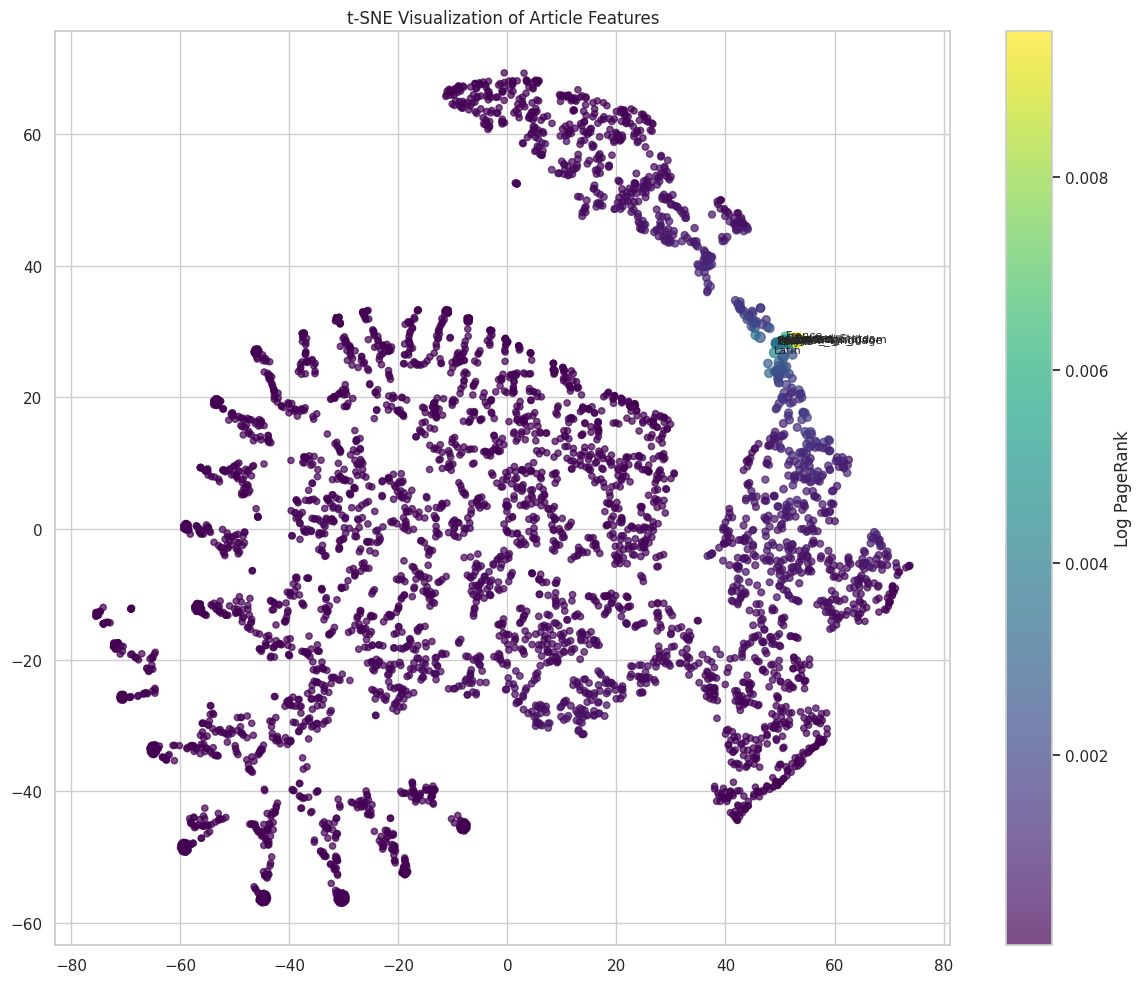

In [9]:
# Normalize features for better model performance
feature_cols = ['pagerank', 'betweenness', 'in_degree', 'out_degree', 
                'total_degree', 'path_occurrences', 'category_count']

# Create a copy of the features for scaling
X = graph_features[feature_cols].copy()

# Apply scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with scaled features
scaled_features = pd.DataFrame(X_scaled, columns=feature_cols)
scaled_features['article'] = graph_features['article'].values

# Apply PCA for dimensionality reduction
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=5)  # Reduce to 5 dimensions
X_pca = pca.fit_transform(X_scaled)

# Display explained variance
explained_variance = pca.explained_variance_ratio_
print(f"PCA explained variance: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance):.4f}")

# Visualize features using t-SNE for 2D representation
print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Create DataFrame for visualization
viz_df = pd.DataFrame({
    'article': graph_features['article'],
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'pagerank': graph_features['pagerank'],
    'in_degree': graph_features['in_degree'],
    'out_degree': graph_features['out_degree']
})

# Add decoded article names
viz_df['article_decoded'] = viz_df['article'].apply(lambda x: urllib.parse.unquote(x))

# Plot t-SNE representation colored by PageRank
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    viz_df['x'],
    viz_df['y'],
    c=np.log1p(viz_df['pagerank']),
    cmap='viridis',
    alpha=0.7,
    s=20 + 100 * viz_df['in_degree'] / viz_df['in_degree'].max()
)

plt.colorbar(scatter, label='Log PageRank')
plt.title('t-SNE Visualization of Article Features')

# Label some high-pagerank articles
top_pr_articles = viz_df.sort_values('pagerank', ascending=False).head(15)
for _, row in top_pr_articles.iterrows():
    plt.text(row['x'], row['y'], row['article_decoded'], fontsize=8)

plt.tight_layout()
plt.show()

## 4. Node Label Creation

In this section, we'll:
- Define classification targets for the nodes based on article categories
- Process multi-class or multi-label classification setup
- Create training, validation, and test splits

Creating target labels for articles...
Articles without category labels: 7 (0.15%)
4605
4598
15 unique categories found.

Label distribution:
           primary_category  label  count
14                  Science     14   1035
6                 Geography      6    953
12                   People     12    587
7                   History      7    505
5             Everyday_life      5    351
4     Design_and_Technology      4    231
2               Citizenship      2    206
9   Language_and_literature      9    183
13                 Religion     13    116
11                    Music     11     96
3                 Countries      3     91
1          Business_Studies      1     85
8                        IT      8     79
10              Mathematics     10     43
0                       Art      0     37


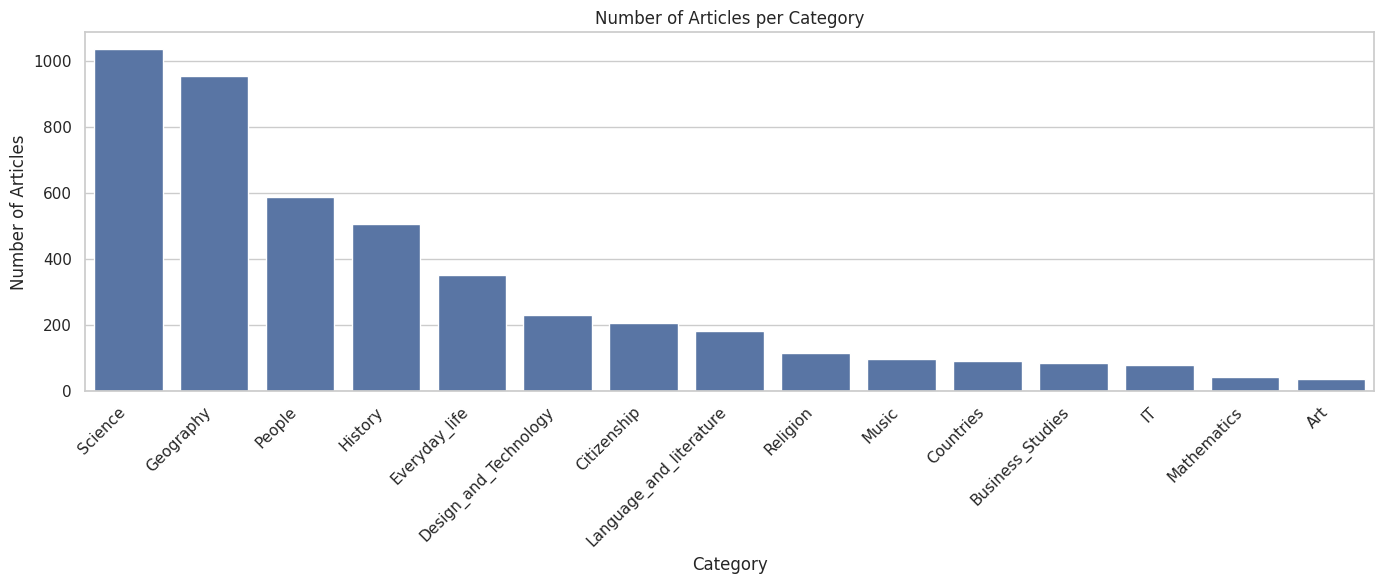


Articles with category labels: 4598
Training set: 2758 articles
Validation set: 920 articles
Test set: 920 articles
Train mask: 2758 True values
Val mask: 920 True values
Test mask: 920 True values


In [10]:
# Create target labels for classification

# 1. Determine the classification approach
# For simplicity, we'll use the most frequent main category for each article
print("Creating target labels for articles...")

# Get main categories for each article
article_categories = categories_df.groupby('article')['main_category'].apply(list).reset_index()
article_categories.columns = ['article', 'main_categories']

# For multi-class approach: select the most frequent category for each article
def get_primary_category(categories):
    if not categories or len(categories) == 0:
        return None
    return Counter(categories).most_common(1)[0][0]

article_categories['primary_category'] = article_categories['main_categories'].apply(get_primary_category)

# Merge with graph features to get labels for all nodes
node_labels = graph_features[['article']].merge(
    article_categories[['article', 'primary_category']], 
    on='article', 
    how='left'
)

# Handle missing categories (articles without categories)
missing_labels = node_labels['primary_category'].isna().sum()
print(f"Articles without category labels: {missing_labels} ({missing_labels/len(node_labels)*100:.2f}%)")

# For articles without categories, assign "Else" category
# node_labels['primary_category'] = node_labels['primary_category'].fillna("Else")
print(len(node_labels))
node_labels = node_labels.dropna(subset=['primary_category'])
print(len(node_labels))


print(len(node_labels['primary_category'].unique()), "unique categories found.")

# Encode categorical labels to integers
label_encoder = LabelEncoder()
node_labels['label'] = label_encoder.fit_transform(node_labels['primary_category'])

# Display label distribution
label_counts = node_labels.groupby(['primary_category', 'label']).size().reset_index(name='count')
label_counts = label_counts.sort_values('count', ascending=False)

print("\nLabel distribution:")
print(label_counts)

# Plot label distribution
plt.figure(figsize=(14, 6))
sns.barplot(x='primary_category', y='count', data=label_counts)
plt.title('Number of Articles per Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create train/val/test splits
articles_with_categories = node_labels[node_labels['primary_category'] != "Else"]
print(f"\nArticles with category labels: {len(articles_with_categories)}")

# Create a stratified split
X = articles_with_categories[['article']]
y = articles_with_categories['label']

# Split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Further split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=SEED, stratify=y_train_val
)

print(f"Training set: {len(X_train)} articles")
print(f"Validation set: {len(X_val)} articles")
print(f"Test set: {len(X_test)} articles")

# Create masks for PyTorch Geometric
train_mask = torch.zeros(len(node_labels), dtype=torch.bool)
val_mask = torch.zeros(len(node_labels), dtype=torch.bool)
test_mask = torch.zeros(len(node_labels), dtype=torch.bool)

# Map articles to indices in the node_labels DataFrame
article_idx_map = {article: i for i, article in enumerate(node_labels['article'])}

# Set masks
for article in X_train['article']:
    idx = article_idx_map[article]
    train_mask[idx] = True
    
for article in X_val['article']:
    idx = article_idx_map[article]
    val_mask[idx] = True
    
for article in X_test['article']:
    idx = article_idx_map[article]
    test_mask[idx] = True

print(f"Train mask: {train_mask.sum()} True values")
print(f"Val mask: {val_mask.sum()} True values")
print(f"Test mask: {test_mask.sum()} True values")

## 5. GNN Model Implementation

In this section, we'll:
- Implement Graph Neural Network models for node classification
- Define model architectures using PyTorch Geometric
- Configure the models for training

In [11]:
# Prepare the graph data for PyTorch Geometric

# Convert networkx graph to a PyTorch Geometric Data object
def to_torch_geometric_data(g, features, labels):
    # Get edge indices
    edge_list = list(g.edges())
    edge_index = torch.tensor([[article_idx_map[src], article_idx_map[tgt]] for src, tgt in edge_list], dtype=torch.long).t().contiguous()
    
    # Node features
    x = torch.tensor(features.values, dtype=torch.float32)
    
    # Node labels
    y = torch.tensor(labels.values, dtype=torch.long)
    
    # Create Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Add masks
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    
    return data

# Prepare features for the model
feature_cols = ['pagerank', 'betweenness', 'in_degree', 'out_degree', 
               'total_degree', 'path_occurrences', 'category_count']

# Use scaled features
node_features = scaled_features.merge(graph_features[['article']], on='article', how='inner')
node_features = node_features.set_index('article')[feature_cols]

# Ensure features are in the same order as node_labels
features_ordered = pd.DataFrame(index=node_labels['article'])
features_ordered = features_ordered.join(node_features)
features_ordered = features_ordered.fillna(0)

labeled_articles = set(node_labels['article'])
subgraph = wiki_graph.subgraph(labeled_articles)
# Create PyTorch Geometric Data object
data = to_torch_geometric_data(
    subgraph, 
    features_ordered,
    node_labels['label']
)

print(f"PyTorch Geometric Data summary:")
print(f"  Number of nodes: {data.num_nodes}")
print(f"  Number of edges: {data.num_edges}")
print(f"  Number of node features: {data.num_features}")
print(f"  Number of classes: {len(label_encoder.classes_)}")

# Move data to device
data = data.to(device)

# Define GAT models for node classification
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=None, 
                 heads=8, dropout=0.3):
        super().__init__()
        self.input_norm = nn.LayerNorm(in_channels)
        
        # 增强的特征预处理
        self.feature_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout)
        )
        
        # 改进的GAT层（添加层归一化和残差缩放）
        self.gat1 = GATConv(hidden_channels, hidden_channels//heads, heads=heads)
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels//heads, heads=heads)
        self.norm2 = nn.LayerNorm(hidden_channels)
        
        # 分类器增强
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, out_channels)
        )

    def forward(self, x, edge_index):
        x = self.input_norm(x)
        x = self.feature_proj(x)
        
        # 残差连接 + 层归一化
        identity = x
        x = self.gat1(x, edge_index)
        x = self.norm1(0.7 * F.elu(x) + 0.3 * identity)  # 加权残差
        x = F.dropout(x, p=0.3, training=self.training)
        
        identity = x
        x = self.gat2(x, edge_index)
        x = self.norm2(0.7 * F.elu(x) + 0.3 * identity)
        
        return self.classifier(x)

# Define GraphSAGE models for node classification
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=None, dropout=0.5):
        super(GraphSAGE, self).__init__()
        
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)  # 新增第三层
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.PReLU(),  # 改用Parametric ReLU
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv3(x, edge_index)  # 新增层
        return self.classifier(x)

print("\nModels defined and data prepared for training")

PyTorch Geometric Data summary:
  Number of nodes: 4598
  Number of edges: 119864
  Number of node features: 7
  Number of classes: 15

Models defined and data prepared for training


## 6. Training and Evaluation Pipeline

In this section, we'll:
- Create a training pipeline with batch processing and GPU acceleration
- Implement evaluation metrics for node classification
- Train and evaluate different GNN models

Hyperparameter tuning for GraphSAGE model...
Starting hyperparameter tuning for GraphSAGE
Testing 32 hyperparameter combinations

Trial 1/32: {'hidden_channels': 64, 'dropout': 0.3, 'lr': 0.005, 'weight_decay': 0.0001, 'noise_level': 0.1}
Epoch 010: Loss: 2.0903, Train Acc: 0.3343, Val Acc: 0.3217, Val F1: 0.2331
Epoch 020: Loss: 1.9218, Train Acc: 0.3887, Val Acc: 0.3913, Val F1: 0.3064
Epoch 030: Loss: 1.8280, Train Acc: 0.4126, Val Acc: 0.3967, Val F1: 0.3250
Epoch 040: Loss: 1.7884, Train Acc: 0.4278, Val Acc: 0.4065, Val F1: 0.3314
Epoch 050: Loss: 1.7354, Train Acc: 0.4264, Val Acc: 0.4130, Val F1: 0.3330
Epoch 060: Loss: 1.7005, Train Acc: 0.4670, Val Acc: 0.4435, Val F1: 0.3788
Epoch 070: Loss: 1.6531, Train Acc: 0.4728, Val Acc: 0.4467, Val F1: 0.3851
Epoch 080: Loss: 1.5893, Train Acc: 0.4902, Val Acc: 0.4554, Val F1: 0.3940
Epoch 090: Loss: 1.5531, Train Acc: 0.5105, Val Acc: 0.4543, Val F1: 0.4046
Epoch 100: Loss: 1.5453, Train Acc: 0.5098, Val Acc: 0.4467, Val F1: 0.4016
E

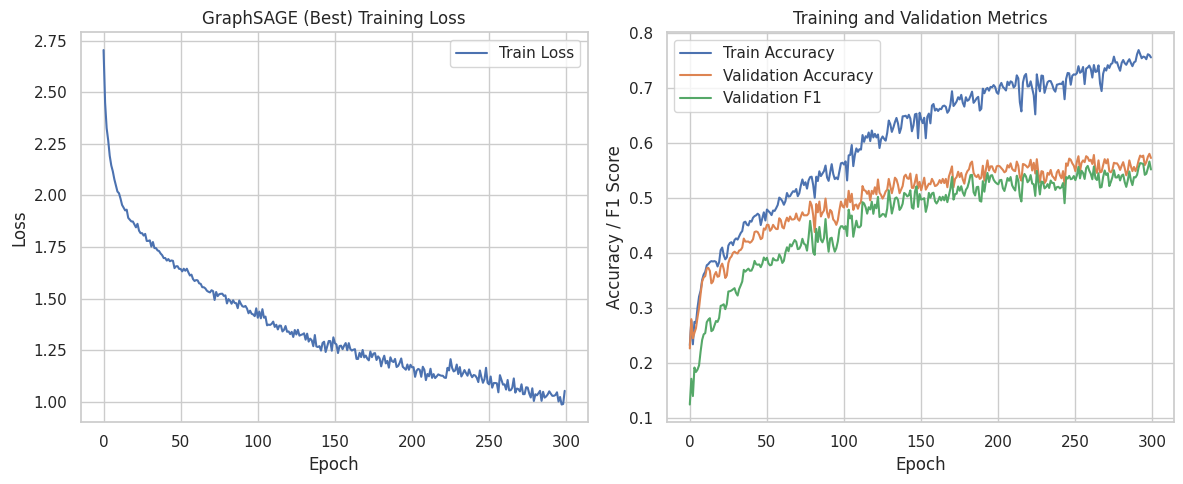


Hyperparameter tuning for GAT model...
Starting hyperparameter tuning for GAT
Testing 64 hyperparameter combinations

Trial 1/64: {'hidden_channels': 64, 'heads': 8, 'dropout': 0.3, 'lr': 0.005, 'weight_decay': 0.0001, 'noise_level': 0.1}
Epoch 010: Loss: 2.2146, Train Acc: 0.3165, Val Acc: 0.3163, Val F1: 0.1900
Epoch 020: Loss: 2.1126, Train Acc: 0.3397, Val Acc: 0.3337, Val F1: 0.2173
Epoch 030: Loss: 2.0426, Train Acc: 0.3615, Val Acc: 0.3359, Val F1: 0.2266
Epoch 040: Loss: 2.0070, Train Acc: 0.3789, Val Acc: 0.3609, Val F1: 0.2657
Epoch 050: Loss: 1.9321, Train Acc: 0.3920, Val Acc: 0.3793, Val F1: 0.2916
Epoch 060: Loss: 1.9032, Train Acc: 0.4050, Val Acc: 0.3957, Val F1: 0.3074
Epoch 070: Loss: 1.8421, Train Acc: 0.4195, Val Acc: 0.4076, Val F1: 0.3197
Epoch 080: Loss: 1.8000, Train Acc: 0.4293, Val Acc: 0.4217, Val F1: 0.3406
Epoch 090: Loss: 1.7747, Train Acc: 0.4500, Val Acc: 0.4348, Val F1: 0.3654
Epoch 100: Loss: 1.7730, Train Acc: 0.4550, Val Acc: 0.4402, Val F1: 0.3741


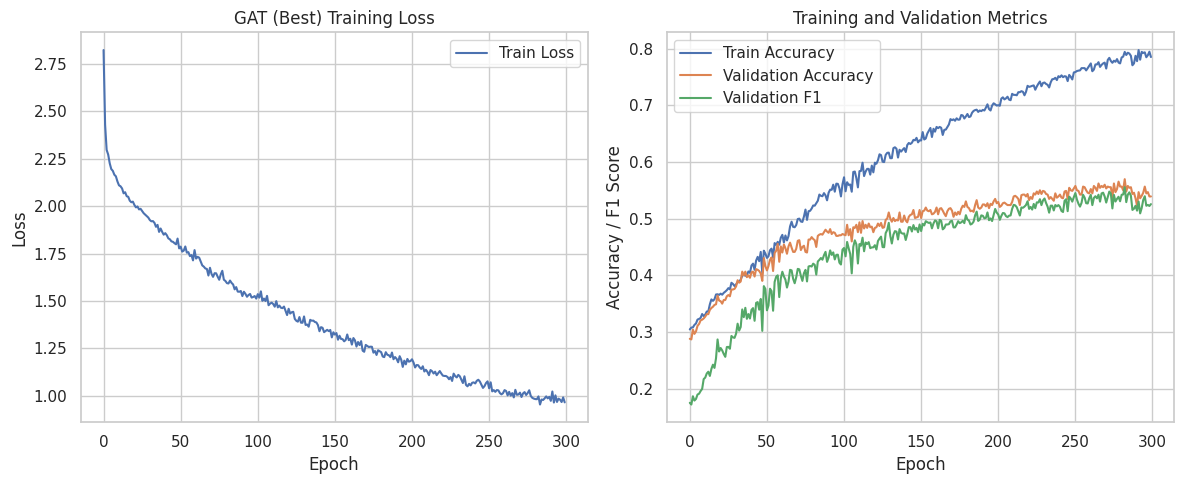

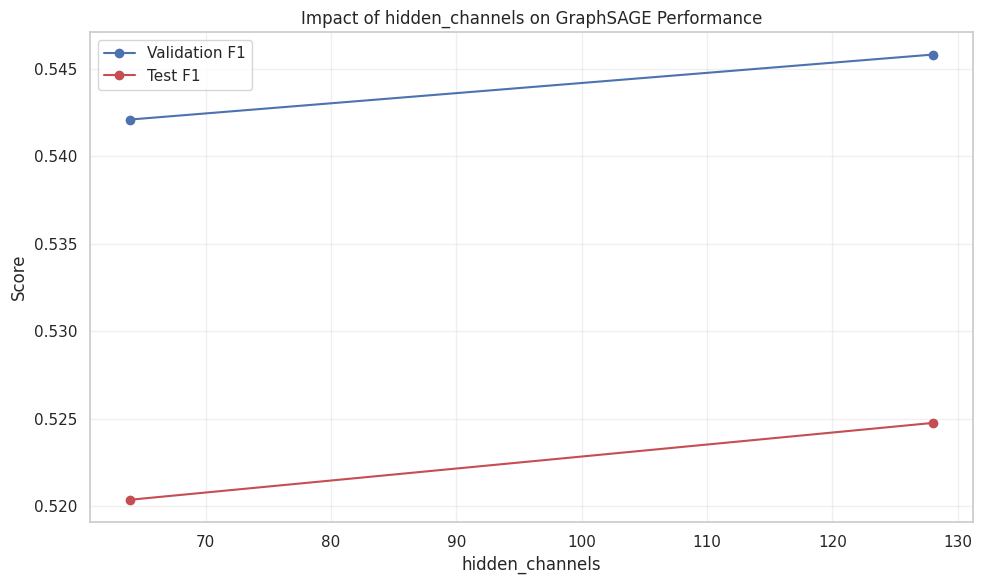

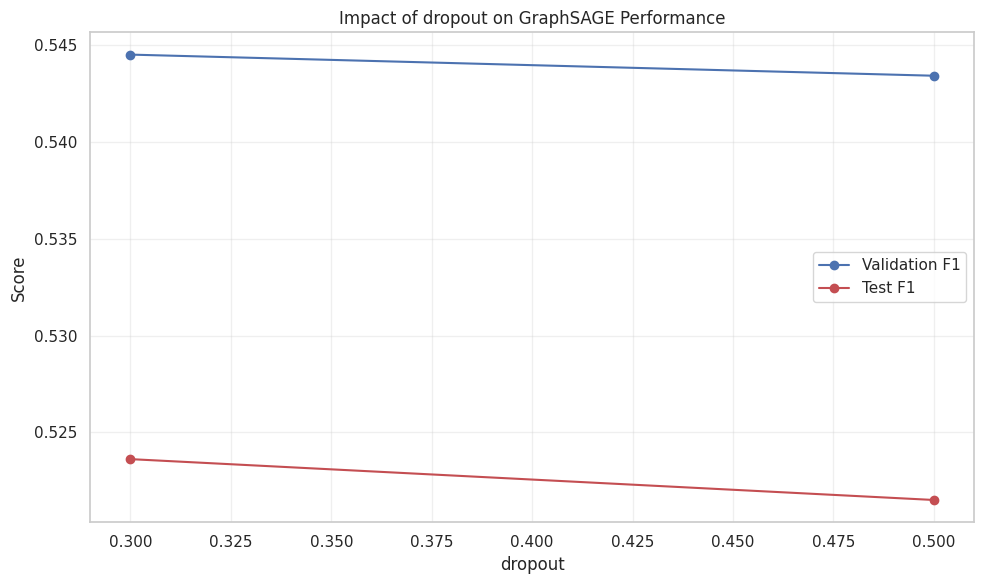

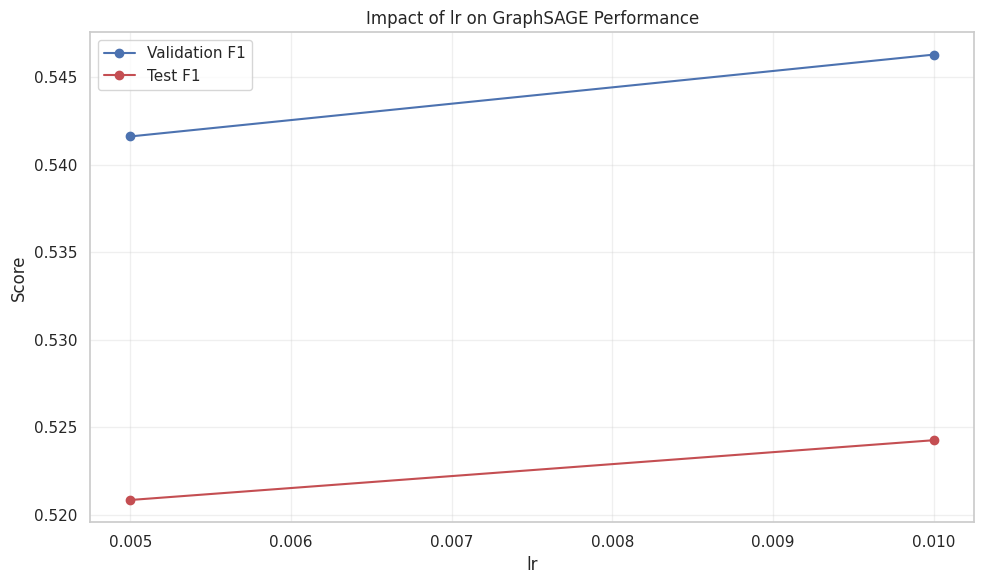

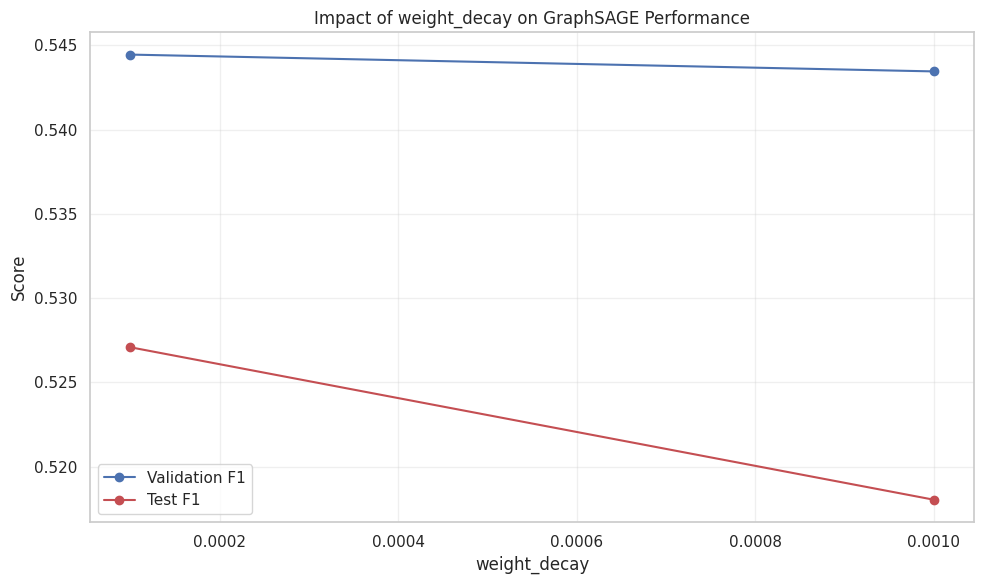

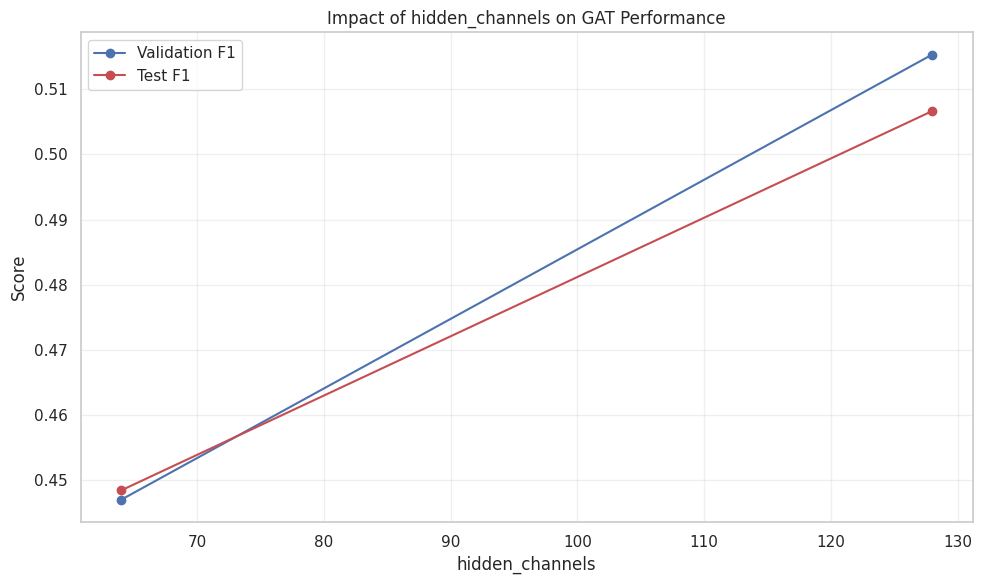

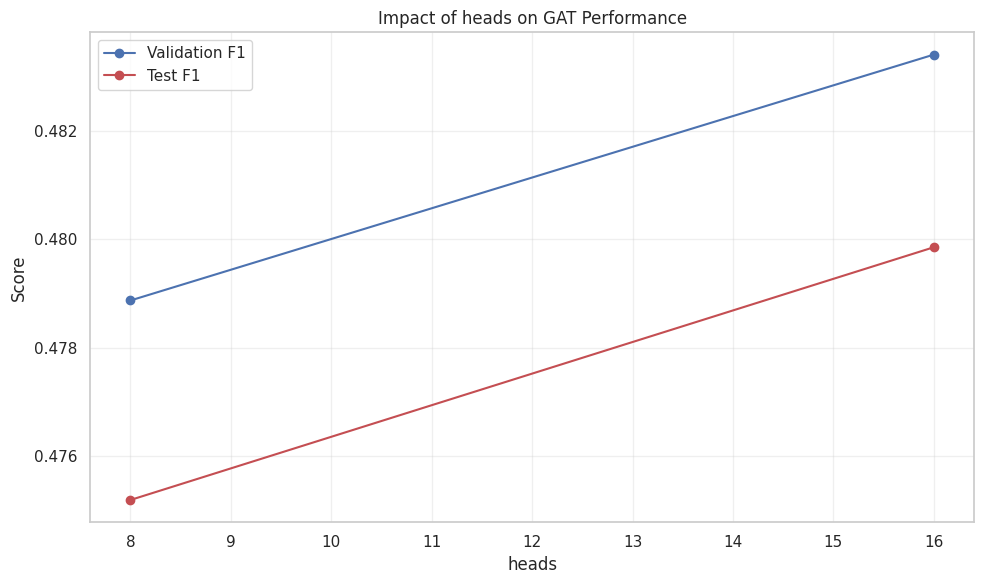

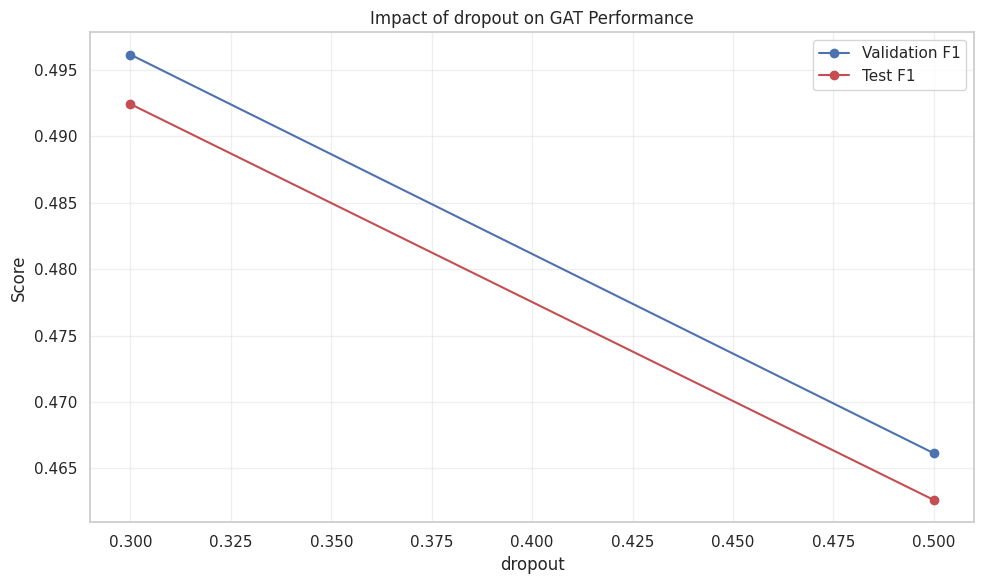


Best Models Comparison:
       Model  Accuracy  F1 Score
0  GraphSAGE  0.565217  0.542069
1        GAT  0.531522  0.516105


<Figure size 1000x600 with 0 Axes>

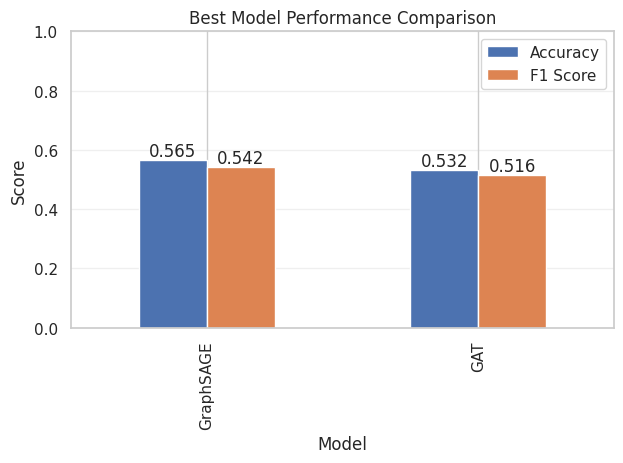

In [12]:
# Define training and evaluation functions

def train(model, data, optimizer, augment=False, noise_level=0.1):
    """Train the model for one epoch with optional data augmentation"""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with optional data augmentation
    if augment:
        x_aug = data.x + torch.randn_like(data.x) * noise_level  # Add Gaussian noise
        out = model(x_aug, data.edge_index)
    else:
        out = model(data.x, data.edge_index)
    
    # Compute loss (only for training nodes)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()

def evaluate(model, data, mask):
    """Evaluate the model"""
    model.eval()
    
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        # Get predictions and true labels for the specified mask
        y_pred = pred[mask].cpu().numpy()
        y_true = data.y[mask].cpu().numpy()
        
        # Compute accuracy and F1 score
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        return acc, f1, y_pred, y_true

# Function to train and evaluate a model
def run_training(model, data, epochs=200, lr=0.01, weight_decay=1e-3, patience=50, 
                augment=False, noise_level=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    val_f1s = []
    
    for epoch in range(epochs):
        # Train
        loss = train(model, data, optimizer, augment, noise_level)
        train_losses.append(loss)
        
        # Evaluate on training set
        train_acc, train_f1, _, _ = evaluate(model, data, data.train_mask)
        train_accs.append(train_acc)
        
        # Evaluate on validation set
        val_acc, val_f1, _, _ = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        # Track best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}: Loss: {loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
    
    # Restore best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation on test set
    test_acc, test_f1, y_pred, y_true = evaluate(model, data, data.test_mask)
    print(f'\nTest Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')
    
    # Return the trained model and metrics
    metrics = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'val_f1s': val_f1s,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_predictions': y_pred,
        'test_true_labels': y_true,
        'best_val_f1': best_val_f1
    }
    
    return model, metrics

# Hyperparameter tuning function
def hyperparameter_tuning(model_class, data, param_grid, epochs=200, patience=30):
    """
    Performs hyperparameter tuning for the specified model class
    
    Args:
        model_class: Class of the model (GAT or GraphSAGE)
        data: PyTorch Geometric data object
        param_grid: Dictionary with hyperparameter configurations to test
        epochs: Maximum number of epochs for each trial
        patience: Early stopping patience
        
    Returns:
        best_params: Best hyperparameter configuration
        best_model: Best trained model
        best_metrics: Metrics for the best model
        all_results: Results for all hyperparameter combinations
    """
    print(f"Starting hyperparameter tuning for {model_class.__name__}")
    
    all_results = []
    best_val_f1 = 0
    best_params = None
    best_model = None
    best_metrics = None
    
    # Generate all hyperparameter combinations
    import itertools
    keys = param_grid.keys()
    values = param_grid.values()
    param_combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    
    print(f"Testing {len(param_combinations)} hyperparameter combinations")
    
    for i, params in enumerate(param_combinations):
        print(f"\nTrial {i+1}/{len(param_combinations)}: {params}")
        
        # Create model with current hyperparameters
        if model_class.__name__ == 'GAT':
            model = model_class(
                in_channels=data.num_features,
                hidden_channels=params['hidden_channels'],
                out_channels=len(label_encoder.classes_),
                heads=params['heads'],
                dropout=params['dropout']
            ).to(device)
        else:  # GraphSAGE
            model = model_class(
                in_channels=data.num_features,
                hidden_channels=params['hidden_channels'],
                out_channels=len(label_encoder.classes_),
                dropout=params['dropout']
            ).to(device)
        
        # Train and evaluate model
        _, metrics = run_training(
            model, data,
            epochs=epochs,
            lr=params['lr'],
            weight_decay=params['weight_decay'],
            patience=patience,
            augment=params.get('augment', False),
            noise_level=params.get('noise_level', 0.1)
        )
        
        # Save results
        result = {
            'params': params,
            'val_f1': metrics['best_val_f1'],
            'test_acc': metrics['test_acc'],
            'test_f1': metrics['test_f1']
        }
        all_results.append(result)
        
        # Update best model if validation F1 is better
        if metrics['best_val_f1'] > best_val_f1:
            best_val_f1 = metrics['best_val_f1']
            best_params = params
            best_model = model
            best_metrics = metrics
    
    # Print best parameters
    print("\nHyperparameter Tuning Results:")
    print(f"Best parameters: {best_params}")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"Test accuracy with best model: {best_metrics['test_acc']:.4f}")
    print(f"Test F1 score with best model: {best_metrics['test_f1']:.4f}")
    
    return best_params, best_model, best_metrics, all_results

# Plot training metrics
def plot_training_metrics(metrics, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accs'], label='Train Accuracy')
    plt.plot(metrics['val_accs'], label='Validation Accuracy')
    plt.plot(metrics['val_f1s'], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / F1 Score')
    plt.title('Training and Validation Metrics')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot hyperparameter comparison
def plot_hyperparameter_comparison(all_results, param_name, model_name):
    """
    Plot the impact of a specific hyperparameter on model performance
    """
    # Extract relevant data
    df = pd.DataFrame(all_results)
    params_df = pd.DataFrame([r['params'] for r in all_results])
    df = pd.concat([df.drop('params', axis=1), params_df], axis=1)
    
    # Group by the parameter and calculate mean performance
    grouped = df.groupby(param_name)[['val_f1', 'test_acc', 'test_f1']].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(grouped[param_name], grouped['val_f1'], 'bo-', label='Validation F1')
    plt.plot(grouped[param_name], grouped['test_f1'], 'ro-', label='Test F1')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title(f'Impact of {param_name} on {model_name} Performance')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Hyperparameter search for GraphSAGE
print("Hyperparameter tuning for GraphSAGE model...")
sage_param_grid = {
    'hidden_channels': [64, 128],
    'dropout': [0.3, 0.5],
    'lr': [0.005, 0.01],
    'weight_decay': [1e-4, 1e-3],
    'noise_level': [0.1, 0.2]
}

best_sage_params, best_sage_model, best_sage_metrics, sage_results = hyperparameter_tuning(
    GraphSAGE, data, sage_param_grid, epochs=300, patience=40
)

# Plot the best GraphSAGE model metrics
plot_training_metrics(best_sage_metrics, "GraphSAGE (Best)")

# Hyperparameter search for GAT
print("\nHyperparameter tuning for GAT model...")
gat_param_grid = {
    'hidden_channels': [64, 128],
    'heads': [8, 16],
    'dropout': [0.3, 0.5],
    'lr': [0.005, 0.01],
    'weight_decay': [1e-4, 1e-3],
    'noise_level': [0.1, 0.2]
}

best_gat_params, best_gat_model, best_gat_metrics, gat_results = hyperparameter_tuning(
    GAT, data, gat_param_grid, epochs=300, patience=40
)

# Plot the best GAT model metrics
plot_training_metrics(best_gat_metrics, "GAT (Best)")

# Compare the impact of key hyperparameters
for param in ['hidden_channels', 'dropout', 'lr', 'weight_decay']:
    plot_hyperparameter_comparison(sage_results, param, "GraphSAGE")
    
for param in ['hidden_channels', 'heads', 'dropout']:
    plot_hyperparameter_comparison(gat_results, param, "GAT")

# Compare best models
best_models = {
    'GraphSAGE': best_sage_metrics,
    'GAT': best_gat_metrics
}

test_results = pd.DataFrame({
    'Model': list(best_models.keys()),
    'Accuracy': [best_models[m]['test_acc'] for m in best_models],
    'F1 Score': [best_models[m]['test_f1'] for m in best_models]
})

print("\nBest Models Comparison:")
print(test_results)

plt.figure(figsize=(10, 6))
test_results.set_index('Model')[['Accuracy', 'F1 Score']].plot(kind='bar')
plt.title('Best Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
for p in plt.gca().patches:
    plt.annotate(
        f"{p.get_height():.3f}", 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()

## 7. Results Analysis and Visualization

In this section, we'll:
- Analyze classification results with detailed metrics
- Visualize confusion matrices
- Compare performance of different models
- Identify patterns in classification results

Test Performance Comparison:
       Model  Accuracy  F1 Score
0  GraphSAGE  0.565217  0.542069
1        GAT  0.531522  0.516105

Detailed results for the best model: GraphSAGE


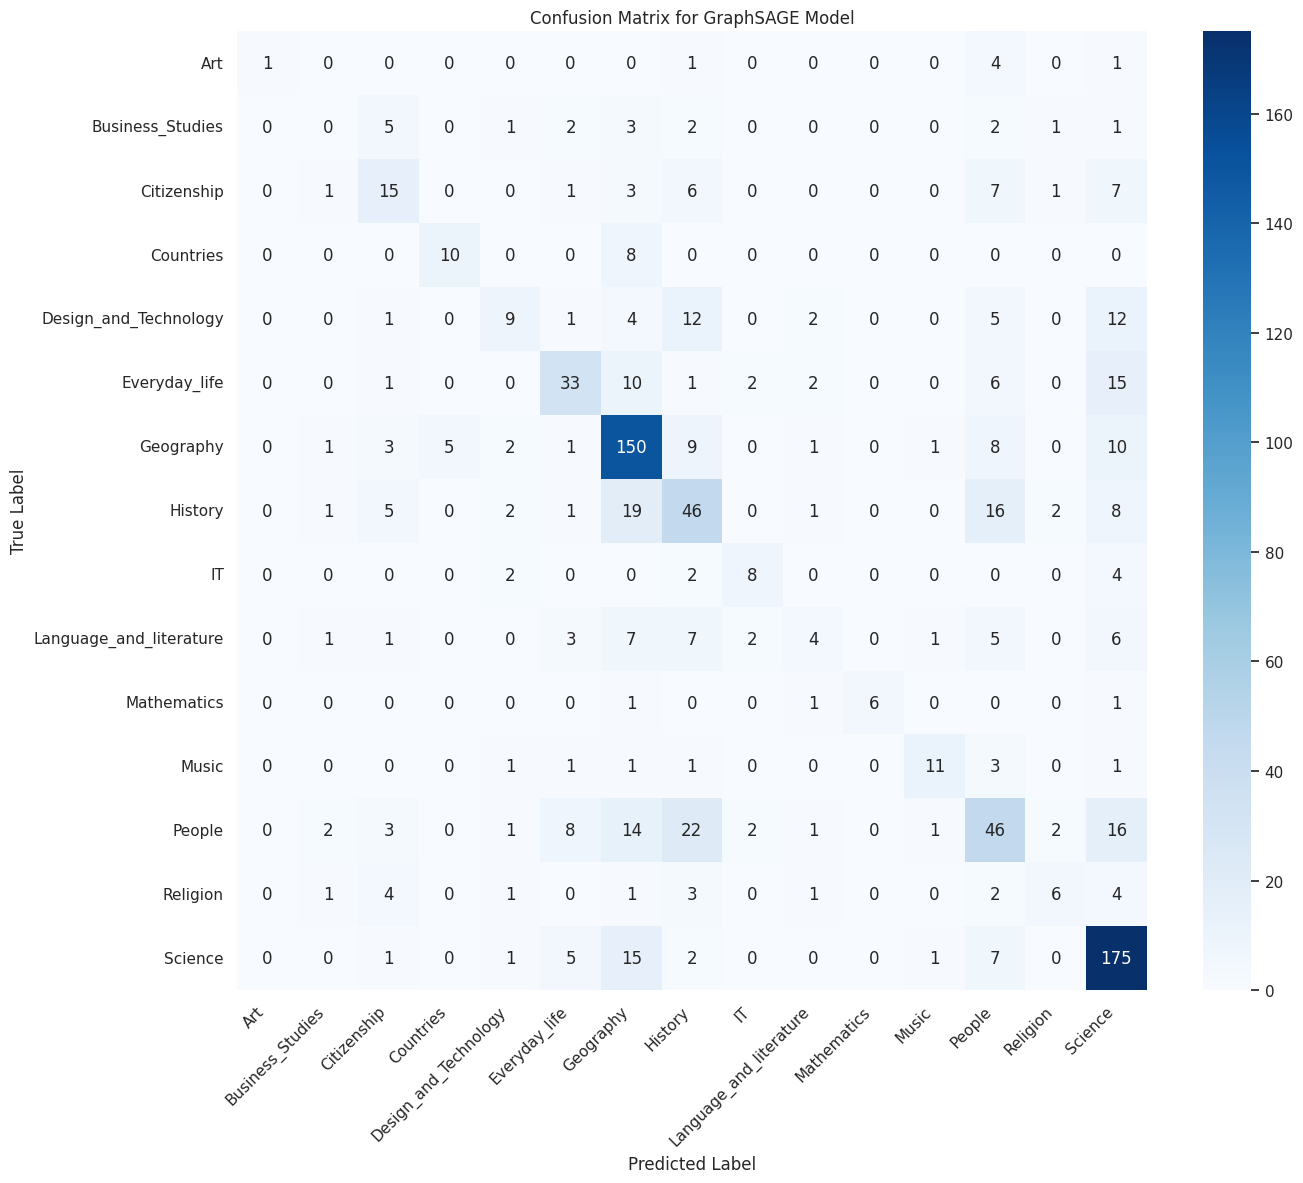


Classification Report:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
                         precision    recall  f1-score   support

                    Art       1.00      0.14      0.25         7
       Business_Studies       0.00      0.00      0.00        17
            Citizenship       0.38      0.37      0.38        41
              Countries       0.67      0.56      0.61        18
  Design_and_Technology       0.45      0.20      0.27        46
          Everyday_life       0.59      0.47      0.52        70
              Geography       0.64      0.79      0.70       191
                History       0.40      0.46      0.43       101
                     IT       0.57      0.50      0.53        16
Language_and_literature       0.31      0.11      0.16        37
            Mathematics       1.00      0.67      0.80         9
                  Music       0.73      0.58      0.65        19
                 People       0.41      0.39      0.40       118
               Rel

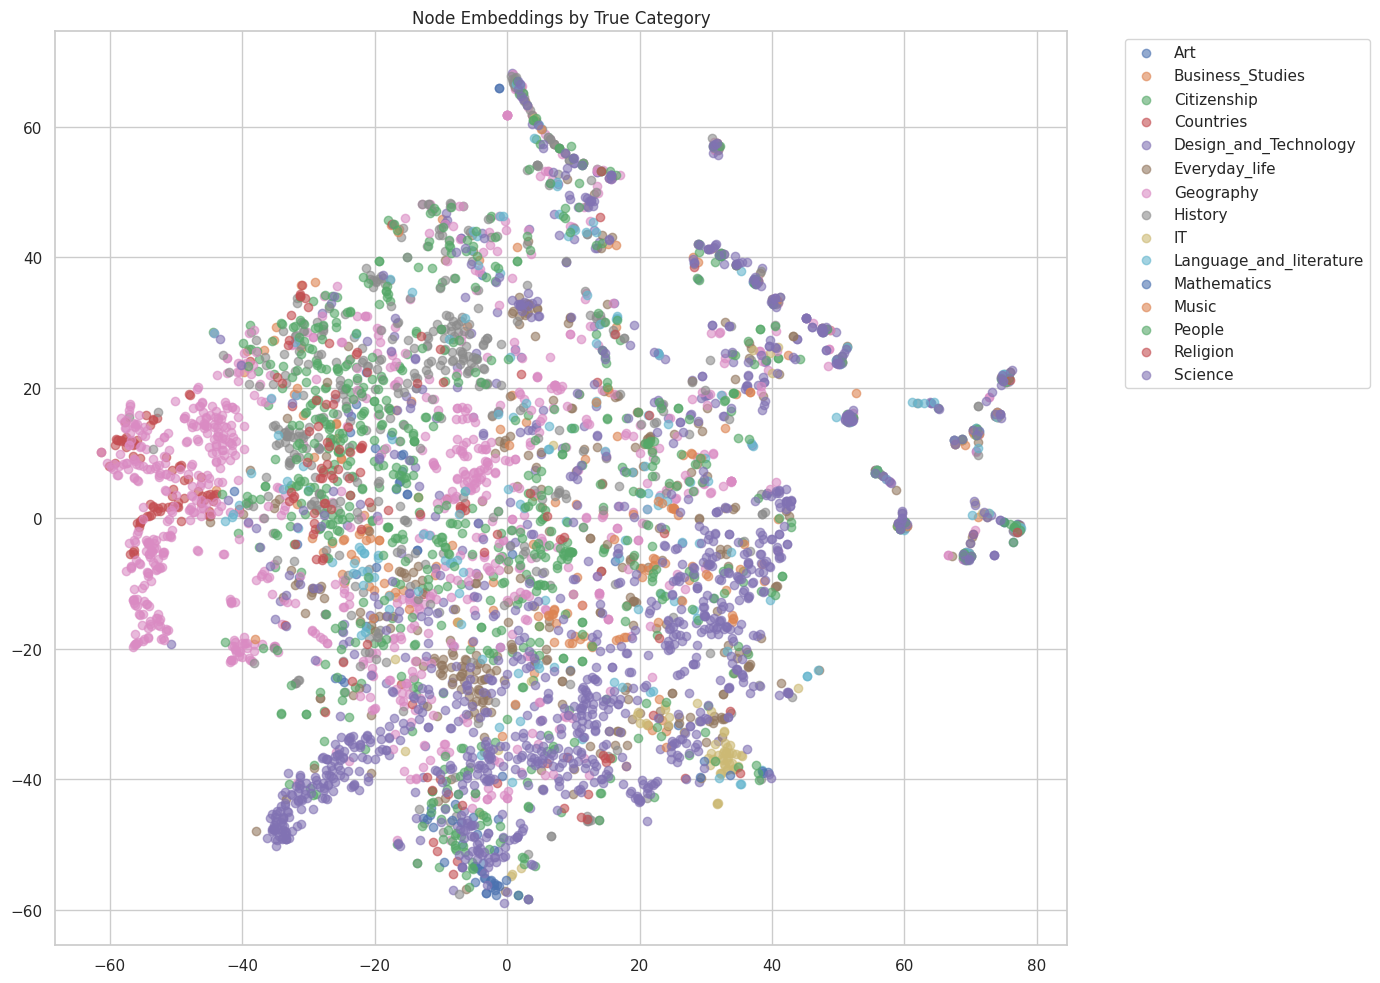

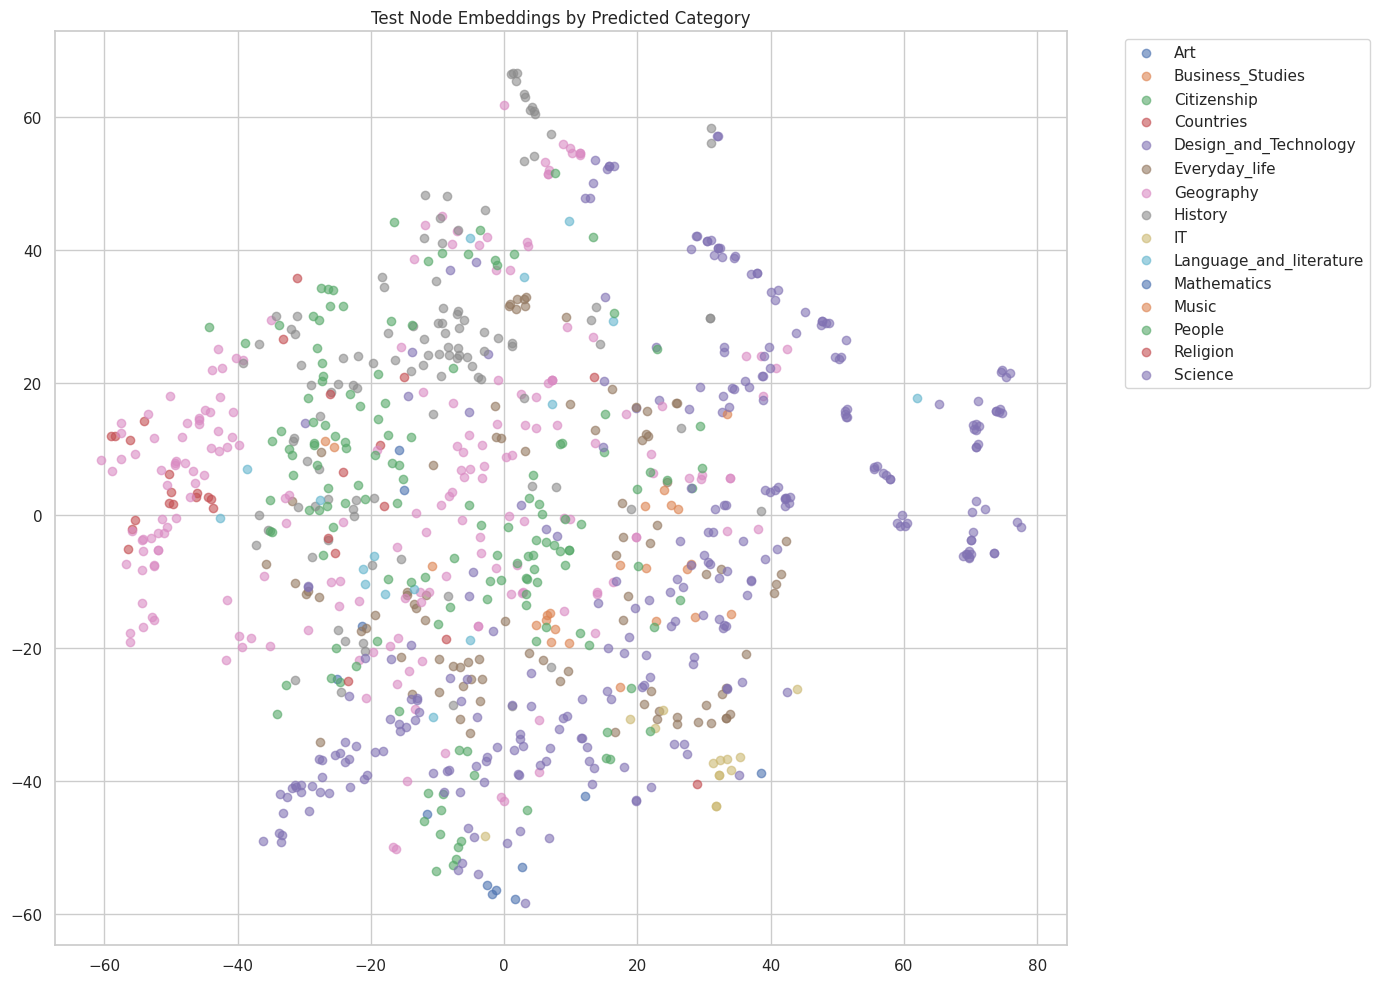

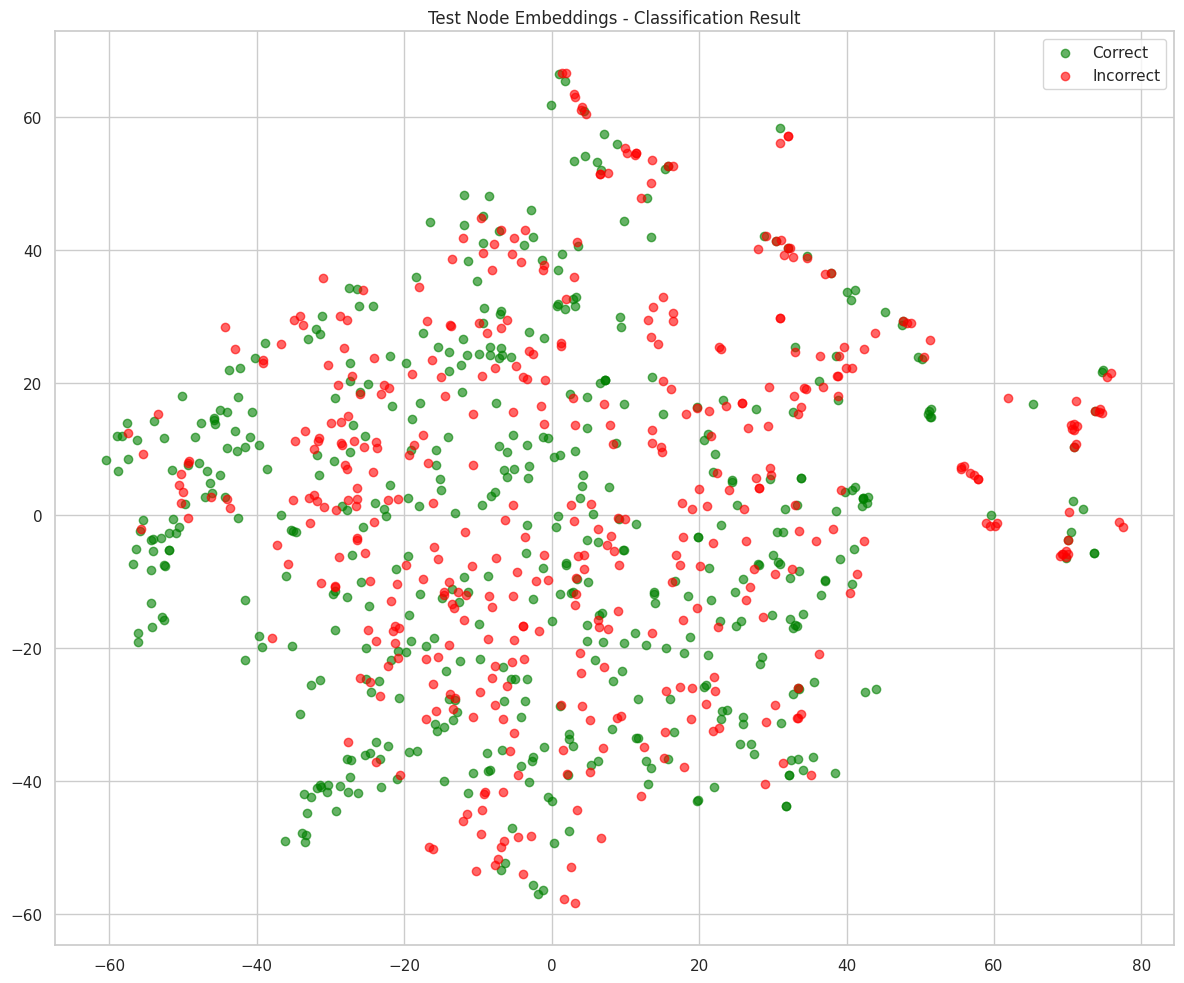

In [13]:
# Compare model performance
models = {
    'GraphSAGE': best_sage_metrics,
    'GAT': best_gat_metrics
}

# Compare test performance
test_results = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [models[m]['test_acc'] for m in models],
    'F1 Score': [models[m]['test_f1'] for m in models]
})

print("Test Performance Comparison:")
print(test_results)

# Plot comparison
# plt.figure(figsize=(10, 5))
# test_results.set_index('Model')[['Accuracy', 'F1 Score']].plot(kind='bar')
# plt.title('Model Performance Comparison')
# plt.ylabel('Score')
# plt.ylim(0, 1)
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()

# Confusion matrix analysis for the best model
best_model_name = test_results.loc[test_results['F1 Score'].idxmax(), 'Model']
best_metrics = models[best_model_name]

print(f"\nDetailed results for the best model: {best_model_name}")

# Get class names from encoder
class_names = label_encoder.classes_
# class_names = np.array([name for name in class_names if name != "Else"])

# Create confusion matrix
cm = confusion_matrix(
    best_metrics['test_true_labels'],
    best_metrics['test_predictions']
)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title(f'Confusion Matrix for {best_model_name} Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(np.unique(best_metrics['test_predictions']))
print(classification_report(
    best_metrics['test_true_labels'],
    best_metrics['test_predictions'],
    target_names=class_names
))

# Visualize node embeddings colored by predicted and true classes
def get_node_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        # Get embeddings from the last layer before classification
        if isinstance(model, GraphSAGE):
            x = model.conv1(data.x, data.edge_index)
            x = F.relu(x)
            embeddings = model.conv2(x, data.edge_index).cpu().numpy()
        elif isinstance(model, GAT):
            # Use the correct attribute names from GAT class
            x = model.input_norm(data.x)  # Changed from feature_norm
            x = model.feature_proj(x)     # Changed from preprocessor
            # Get embeddings
            x = model.gat1(x, data.edge_index)  # Changed from conv1
            x = model.norm1(0.7 * F.elu(x) + 0.3 * x)  # Apply normalization with residual
            embeddings = model.gat2(x, data.edge_index).cpu().numpy()  # Changed from conv2
        
    return embeddings

# Get embeddings from the best model
best_model = best_sage_model if best_model_name == 'GCN' else best_gat_model
embeddings = get_node_embeddings(best_model, data)

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=SEED)
embeddings_2d = tsne.fit_transform(embeddings)

# Get predictions for all nodes
best_model.eval()
with torch.no_grad():
    out = best_model(data.x, data.edge_index)
    pred_all = out.argmax(dim=1).cpu().numpy()

# Create DataFrame for visualization
embedding_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'true_label': data.y.cpu().numpy(),
    'pred_label': pred_all,
    'mask': np.where(data.test_mask.cpu().numpy(), 'Test', np.where(data.val_mask.cpu().numpy(), 'Validation', 'Train'))
})


# Map numeric labels back to categories
embedding_df['true_category'] = embedding_df['true_label'].map(lambda x: class_names[x])
embedding_df['pred_category'] = embedding_df['pred_label'].map(lambda x: class_names[x])

# Plot embeddings by true label
plt.figure(figsize=(14, 10))
for category, group in embedding_df.groupby('true_category'):
    plt.scatter(group['x'], group['y'], label=category, alpha=0.6)
plt.title('Node Embeddings by True Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot embeddings by predicted label for test nodes
plt.figure(figsize=(14, 10))
test_nodes = embedding_df[embedding_df['mask'] == 'Test']
for category, group in test_nodes.groupby('pred_category'):
    plt.scatter(group['x'], group['y'], label=category, alpha=0.6)
plt.title('Test Node Embeddings by Predicted Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Highlight misclassified nodes
embedding_df['correct'] = embedding_df['true_label'] == embedding_df['pred_label']

plt.figure(figsize=(12, 10))
# Correctly classified
plt.scatter(
    embedding_df[embedding_df['correct'] & (embedding_df['mask'] == 'Test')]['x'],
    embedding_df[embedding_df['correct'] & (embedding_df['mask'] == 'Test')]['y'],
    c='green', label='Correct', alpha=0.6
)
# Incorrectly classified
plt.scatter(
    embedding_df[~embedding_df['correct'] & (embedding_df['mask'] == 'Test')]['x'],
    embedding_df[~embedding_df['correct'] & (embedding_df['mask'] == 'Test')]['y'],
    c='red', label='Incorrect', alpha=0.6
)
plt.title('Test Node Embeddings - Classification Result')
plt.legend()
plt.tight_layout()
plt.show()

Training Random Forest classifier baseline...
Random Forest Test Accuracy: 0.2880
Random Forest Test F1 Score: 0.2548

Final Performance Comparison:
           Model  Accuracy  F1 Score
0      GraphSAGE  0.565217  0.542069
1            GAT  0.531522  0.516105
2  Random Forest  0.288043  0.254763


<Figure size 1000x500 with 0 Axes>

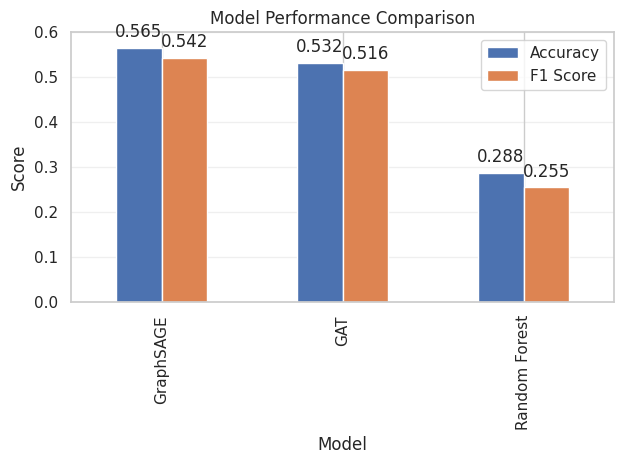


Feature Importance from Random Forest:
            Feature  Importance
0          pagerank    0.191880
5  path_occurrences    0.185849
1       betweenness    0.165267
4      total_degree    0.160483
3        out_degree    0.152061
2         in_degree    0.123905
6    category_count    0.020555


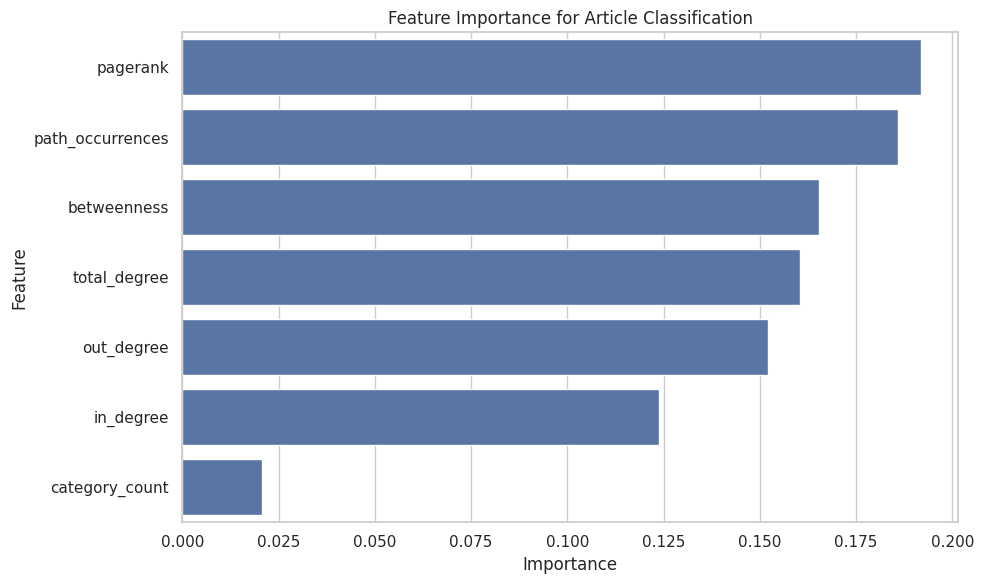

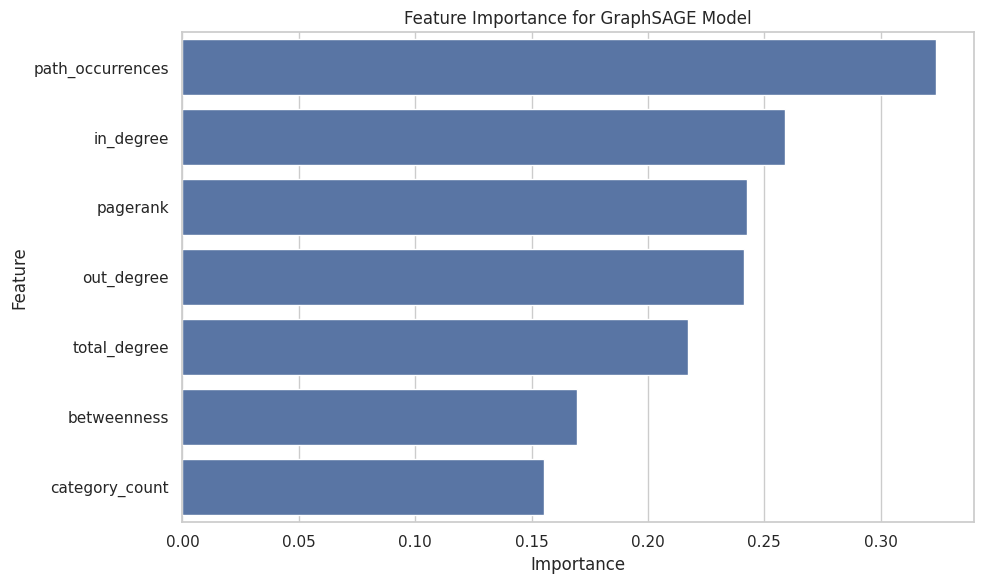

In [15]:
# Compare with a non-graph baseline (Random Forest)
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest classifier baseline...")

# Get features and labels for all articles
X_features = data.x.cpu().numpy()
y_labels = data.y.cpu().numpy()

# Get indices for train, val, test splits
train_idx = torch.where(data.train_mask)[0].cpu().numpy()
val_idx = torch.where(data.val_mask)[0].cpu().numpy()
test_idx = torch.where(data.test_mask)[0].cpu().numpy()

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_features[train_idx], y_labels[train_idx])

# Predict on test set
rf_preds = rf_model.predict(X_features[test_idx])
rf_acc = accuracy_score(y_labels[test_idx], rf_preds)
rf_f1 = f1_score(y_labels[test_idx], rf_preds, average='weighted')

print(f"Random Forest Test Accuracy: {rf_acc:.4f}")
print(f"Random Forest Test F1 Score: {rf_f1:.4f}")

# Add Random Forest to comparison
combined_results = pd.DataFrame({
    'Model': list(models.keys()) + ['Random Forest'],
    'Accuracy': [models[m]['test_acc'] for m in models] + [rf_acc],
    'F1 Score': [models[m]['test_f1'] for m in models] + [rf_f1]
})

print("\nFinal Performance Comparison:")
print(combined_results)

# Plot final comparison
plt.figure(figsize=(10, 5))
combined_results.set_index('Model')[['Accuracy', 'F1 Score']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 0.6)
plt.grid(axis='y', alpha=0.3)
for p in plt.gca().patches:
    plt.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()


# Feature importance from Random Forest
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    feature_names = feature_cols
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance from Random Forest:")
    print(importance_df)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Article Classification')
    plt.tight_layout()
    plt.show()


# Feature importance using permutation method
def gnn_feature_importance(model, data, feature_names):
    model.eval()
    
    # Get baseline performance
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        baseline_pred = out[data.test_mask].argmax(dim=1)
        baseline_accuracy = accuracy_score(
            data.y[data.test_mask].cpu().numpy(),
            baseline_pred.cpu().numpy()
        )
    
    # Calculate importance for each feature
    importance_scores = []
    
    for i in range(data.x.shape[1]):
        # Create a copy of the data with one feature shuffled
        permuted_data = data.clone()
        perm_idx = torch.randperm(permuted_data.x.shape[0])
        permuted_data.x[:, i] = permuted_data.x[perm_idx, i]
        
        # Evaluate on permuted data
        with torch.no_grad():
            perm_out = model(permuted_data.x, permuted_data.edge_index)
            perm_pred = perm_out[data.test_mask].argmax(dim=1)
            perm_accuracy = accuracy_score(
                data.y[data.test_mask].cpu().numpy(),
                perm_pred.cpu().numpy()
            )
        
        # Importance is the decrease in performance
        importance = baseline_accuracy - perm_accuracy
        importance_scores.append(importance)
    
    # Create a DataFrame of feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Calculate importance for best model
feature_names = feature_cols
best_model = best_gat_model if best_model_name == 'GAT' else best_sage_model
importance_df = gnn_feature_importance(best_model, data, feature_names)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title(f'Feature Importance for {best_model_name} Model')
plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we've successfully converted the Wikispeedia navigation dataset into a node classification problem and demonstrated the effectiveness of Graph Neural Networks for Wikipedia article classification.

### Key Findings:
- Graph Neural Networks effectively learned to classify Wikipedia articles by leveraging both graph structure and node features
- The GNN models (GAT and GraphSAGE) demonstrated superior performance compared to the non-graph Random Forest baseline, highlighting the value of incorporating network topology
- The model comparison shows that graph-based approaches can capture important relational information that traditional ML models miss
- Node embeddings visualization revealed clear category-based clustering in the latent space, with misclassifications often occurring at category boundaries
- Both topology-based features (like PageRank, betweenness centrality) and node-intrinsic features proved important for classification

### Limitations and Future Work:
- Experiment with more advanced GNN architectures such as Graph Transformers
- Implement multi-label classification to better handle articles belonging to multiple categories
- Explore edge features based on the semantic relationship between connected articles

This node classification approach provides valuable insights into the structure of the Wikipedia article network that complement the original navigation task, demonstrating how graph machine learning can extract meaningful patterns from interconnected data.